# BASE

### IMPORT

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates, ticker as ticker
from matplotlib.widgets import CheckButtons

#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split #????????????????????
from sklearn.model_selection import KFold #K-FOLD KROSWALIDACJA

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import numpy as np
import seaborn as sns
import datetime

### FUNCTIONS

In [2]:
def cols_to_numeric(*args):
    result = []
    for arg in args:
        arg = pd.to_numeric(arg, errors='coerce')
        result.append(arg)
    return result
 

def create_periods(df):
    result = [None] * 5
    result[0] = df.iloc[len(df.index)-(24*1):]
    result[1] = df.iloc[len(df.index)-(24*2):]
    result[2] = df.iloc[len(df.index)-(24*3):]
    result[3] = df.iloc[len(df.index)-(24*7):]
    result[4] = df.iloc[len(df.index)-(24*14):]
    result[0].reset_index(inplace = True, drop = True)
    result[1].reset_index(inplace = True, drop = True)
    result[2].reset_index(inplace = True, drop = True)
    result[3].reset_index(inplace = True, drop = True)
    result[4].reset_index(inplace = True, drop = True)
    return result

In [3]:
%matplotlib widget
def draw_line_graph(df, title, ex_tick='month'):
    colors = ['silver','darkgreen','red','deepskyblue', 'gold', 'blueviolet', 'mediumorchid', 'lawngreen', 'aqua',
             'purple', 'blue', 'darkgoldenrod', 'darkorange', 'magenta', 'forestgreen', 'midnightblue']
    lines = []
    check_labels = []
    check_states = []
    
    fig, ax = plt.subplots(figsize=(17,10));
    for column, clr in zip(df, colors):
        if column != 'Date':
            l, = ax.plot(df['Date'], df[column], color=clr, alpha=0.5, linewidth=2)
            lines.append(l)
            check_states.append(l.get_visible())
            check_labels.append(column.rsplit('[', 1)[0])
    
    #plot apperance
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha='left');
    plt.subplots_adjust(left=0.23)
    ax.set_title(title);
    ax.grid();
    ax.set_ylabel(('[' + column.rsplit('[', 1)[1]),fontsize = 16);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(25));
    ax.set_xlabel('', fontsize = 16);
    if ex_tick == 'day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1));
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a-%d-%m-%y'));
    elif ex_tick == 'hour':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval = 3));
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1));
    
    
    #checkboxes
    ax_checkbox = plt.axes([0.03, 0.6, 0.17, 0.3])
    checkboxes = CheckButtons(ax_checkbox, check_labels, check_states)
    [rec.set_facecolor(colors[i+1]) for i, rec in enumerate(checkboxes.rectangles)]
    def callback(label):
        index = check_labels.index(label)
        lines[index].set_visible(not lines[index].get_visible())
        plt.draw()
    checkboxes.on_clicked(callback)
    
    return checkboxes

In [4]:
def df_corr_3days(original_df, day = 0):
    df = pd.DataFrame(index=range(0, 24))
    for column in original_df:
        if column != 'Date':
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+1)):].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' tomorrow'}, inplace = True)
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+2)):len(price_all.index)-(24*(day+1))].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' today'}, inplace = True)
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+3)):len(price_all.index)-(24*(day+2))].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' yesterday'}, inplace = True)
    
    return df

In [5]:
def generate_df_weeks(price_df,gener_df,consu_df,ratio = 0.2,weeks = 7,drop_latest_weeks = 0,drop_earliest_weeks = 0,
                          cols=['Poland[€/MWh]','Germany/Luxembourg[€/MWh]','Czech Republic[€/MWh]','Austria[€/MWh]']):
    
    
    df_bufor = price_df[cols].copy()
    
    #CO ZROBIC Z NA?????????????????????????????????????????????????????????????????????????????????????????????????????????????????
    df_bufor = df_bufor.fillna(0)#??????????????????????????????????????????????????????????????????????????????????????????????????
    #df_bufor = df_bufor.dropna()
    df_bufor.reset_index(inplace = True, drop = True)
    #======================================
    
    #DODANIE KONSUMPCJI ELEKTRYCZNOŚCI
    bufor_series = consu_df['Total (grid load)[MWh]']
    #bufor_series = bufor_series.groupby(bufor_series.index//4).sum()
    #df_bufor['consu. total (grid load)[MWh]'] = bufor_series
    df_bufor['consu. total (grid load)[MWh]'] = bufor_series.groupby(bufor_series.index//4).sum()
    #======================================
    
    #DODANIE PRODUKCJI ELEKTRYCZNOŚCI
    bufor_series = gener_df.sum(axis=1, numeric_only=True)
    #bufor_series = bufor_series.groupby(bufor_series.index//4).sum()
    #df_bufor['gener. total[MWh]'] = bufor_series
    df_bufor['gener. total[MWh]'] = bufor_series.groupby(bufor_series.index//4).sum()
    #======================================
    
    #ZAMIANA DATY NA DNI TYGODNIA I GODZINY
    df_bufor['Weekday'] = price_df['Date'].dt.day_of_week
    df_bufor['Hour'] = price_df['Date'].dt.hour
    df_bufor['Date'] = price_df['Date']    
    #======================================
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #OSTATNIE weeks tygodni (+1 zapasu do odrzucenia) (weeks*7*24+1*7*24=weeks*7*24+168)
    df_bufor = df_bufor.tail((weeks*7*24)+168)
    df_bufor.reset_index(inplace = True, drop = True)
    #======================================
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    #KOLUMNA WYJŚCIOWA (wrzucona w całość, zamiast osobnego dataframe, by operować na jednym dataframe podczas przycinania dataframe'ów)
    #cols = cols[0:2]
    df = df_bufor.copy()
    df['Outcome'] = df[cols[0]]
    df = df.drop(cols[0:2],axis=1)
    #======================================
    
    #TWORZENIE DATAFRAMÓW Z KRAJAMI I Z WAŻNYMI KRAJAMI, ZMIANA NAZW (WAŻNE KRAJE = POLSKA NIEMCY, DWA PIERWSZE W LIŚCIE columns)
    df_bufor = df_bufor.drop(['consu. total (grid load)[MWh]','gener. total[MWh]','Weekday','Hour','Date'],axis=1)
    bufor_series = df_bufor[cols[0:2]]
    df_bufor.columns = df_bufor.columns.str.rstrip('[€/MWh]')
    df_bufor = df_bufor.add_suffix(' -1 day')
    bufor_series.columns = bufor_series.columns.str.rstrip('[€/MWh]')
    bufor_series = bufor_series.add_suffix(' -2 days')
    #======================================
    
    #OPÓŹNIENIE O DZIEŃ (-1 df -1 df_bufor)
    df = df.iloc[24:,:]
    df.reset_index(inplace = True, drop = True)
    df_bufor = df_bufor.iloc[:-24,:]
    df = df.join(df_bufor)
    #======================================
    
    #OPÓŹNIENIE O 2 DNI (-1 df -2 bufor_series)
    df = df.iloc[24:,:]
    df.reset_index(inplace = True, drop = True)
    bufor_series = bufor_series.iloc[:-48,:]
    df = df.join(bufor_series)
    #======================================
    
    #OPÓŹNIENIE O TYDZIEŃ (-5 df -5 bufor_series) (5*24=120)
    bufor_series.columns = bufor_series.columns.str.rstrip('2 days')
    bufor_series = bufor_series.add_suffix('7 days')
    df = df.iloc[120:,:]
    df.reset_index(inplace = True, drop = True)
    bufor_series = bufor_series.iloc[:-120,:]
    df = df.join(bufor_series)
    #======================================
    
    #======================================
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #======================================
    #OPUSZCZENIE OSTATNIEGO OGONA (NAJNOWSZE OBSERWACJE)
    df.drop(df.tail(drop_latest_weeks*7*24).index,inplace = True)
    #OPUSZCZENIE OSTATNIEGO GŁOWY (NAJSTARSZE OBSERWACJE
    df.drop(df.head(drop_earliest_weeks*7*24).index,inplace = True)
    df.reset_index(inplace = True, drop = True)
    #======================================
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #======================================
    
    #ODZIELENIE WYJŚCIOWEGO DATAFRAME I KOLUMNY Z DATĄ
    df_bufor = df['Outcome'].copy()
    
    bufor_series = df['Date'].copy()
    df = df.drop(columns = 'Date')
    
    df = df.drop(columns = 'Outcome')
    #df_bufor = df_bufor.values.reshape(-1,1)
    #==========================================
    
    #NORMALIZACJA
    cols = list(df.columns)
    cols = [e for e in cols if e not in ('consu. total (grid load)[MWh]','gener. total[MWh]','Weekday','Hour')]
    #cols = [e for e in cols if e not in ('Weekday','Hour')]
    df[cols] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df[cols])
    #df[cols] = MaxAbsScaler().fit_transform(df[cols])
    #df[cols] = StandardScaler().fit_transform(df[cols])
    #==========================================
    
    #DUMMIES (ONEHOTENCODING)
    df = pd.get_dummies(df, columns=['Weekday','Hour'])
    #cols = list(df.filter(like='Weekday').columns)        #????????????????
    #df[cols] = df[cols].astype('bool')                    #BINARYZACJA? NIC NIE ZMIENIA
    #cols = list(df.filter(like='Hour').columns)           #BINARYZACJA?
    #df[cols] = df[cols].astype('bool')                    #????????????????
    #==========================================
    
    return [df,df_bufor,bufor_series];

# DATA MANAGEMENT

### LOAD DATA

In [6]:
price_og       = pd.read_csv('price_1.csv',       sep=';')
generation_og  = pd.read_csv('generation_1.csv',  sep=';')
consumption_og = pd.read_csv('consumption_1.csv', sep=';')
#consumption_og
#consumption_og.dtypes

### WORK COPY

In [7]:
price_all  = price_og.copy()
gener_all  = generation_og.copy()
consu_all = consumption_og.copy()

#Consolidate date columns
price_all['Date'] = price_all['Date'] + ' ' + price_all['Time of day']
price_all['Date'] = pd.to_datetime(price_all['Date'], errors='coerce')
gener_all['Date'] = gener_all['Date'] + ' ' + gener_all['Time of day']
gener_all['Date'] = pd.to_datetime(gener_all['Date'], errors='coerce')
consu_all['Date'] = consu_all['Date'] + ' ' + consu_all['Time of day']
consu_all['Date'] = pd.to_datetime(consu_all['Date'], errors='coerce')

#delete redundant column
price_all.drop(labels = 'Time of day', axis  = 1, inplace=True);
gener_all.drop(labels = 'Time of day', axis  = 1, inplace=True);
consu_all.drop(labels = 'Time of day', axis  = 1, inplace=True);

price_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);
#gener_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);
#consu_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);


price_all = price_all.replace(',','.', regex=True)
gener_all = gener_all.replace(',','.', regex=True)
consu_all = consu_all.replace(',','.', regex=True)

In [8]:
price_all

Date  Germany/Luxembourg[€/MWh] Denmark 1[€/MWh]  \
0     2019-07-01 00:00:00                      28.98            27.49   
1     2019-07-01 01:00:00                      26.23            25.39   
2     2019-07-01 02:00:00                      25.04            24.22   
3     2019-07-01 03:00:00                      24.94            24.07   
4     2019-07-01 04:00:00                      26.04            25.07   
...                   ...                        ...              ...   
21212 2021-11-30 19:00:00                     232.60            232.6   
21213 2021-11-30 20:00:00                     215.06           215.06   
21214 2021-11-30 21:00:00                     171.89           171.89   
21215 2021-11-30 22:00:00                     145.89           145.89   
21216 2021-11-30 23:00:00                     126.94           126.94   

      Denmark 2[€/MWh]  France[€/MWh]  Northern Italy[€/MWh]  \
0                27.49          28.98                  55.00   
1                25.39          26.23                  47.80   
2                24.22          24.26                  42.07   
3                24.07          21.42                  41.96   
4                25.07          19.61                  41.96   
...                ...            ...                    ...   
21212            232.6         302.60                 314.00   
21213           215.06         290.01                 290.01   
21214           171.89         245.45                 245.45   
21215           145.89         234.93                 234.93   
21216           126.94         223.99                 223.99   

       Netherlands[€/MWh] Poland[€/MWh]  Sweden 4[€/MWh]  Switzerland[€/MWh]  \
0                   28.98             -            20.71               26.97   
1                   26.23             -            19.82               25.71   
2                   25.02             -            19.84               24.27   
3                   24.87             -            20.56               23.91   
4                   25.90             -            21.09               23.21   
...                   ...           ...              ...                 ...   
21212              232.60        146.22           232.60              304.67   
21213              214.43        127.77           215.06              293.07   
21214              172.51        127.77           171.89              258.94   
21215              146.05        142.39           142.39              244.51   
21216              126.94        123.89           123.89              238.80   

       Slovenia[€/MWh] Czech Republic[€/MWh] Hungary[€/MWh]  Austria[€/MWh]  \
0                55.00                 28.91          39.49           28.98   
1                47.80                 27.37          27.91           26.23   
2                42.07                 26.03          26.03           25.04   
3                41.96                 26.05          26.05           24.94   
4                41.96                    26             26           26.04   
...                ...                   ...            ...             ...   
21212           247.07                 232.6         247.07          247.07   
21213           230.43                215.06         230.43          230.43   
21214           191.91                171.89         191.91          191.91   
21215           172.26                145.89         172.26          172.26   
21216           155.68                126.94         155.68          155.68   

       Belgium[€/MWh]  Norway 2[€/MWh]  
0               28.98            27.49  
1               26.23            25.39  
2               24.50            24.22  
3               22.52            24.07  
4               21.61            25.07  
...               ...              ...  
21212          238.81           225.39  
21213          220.55           208.39  
21214          170.00           166.99  
21215          185.63           141.37  
21216         

In [41]:
gener_all

Date  Biomass[MWh]  Hydropower[MWh]  Wind offshore[MWh]  \
0     2019-07-01 00:00:00         1.144              617               1.014   
1     2019-07-01 00:15:00         1.142              573               1.029   
2     2019-07-01 00:30:00         1.142              590               1.040   
3     2019-07-01 00:45:00         1.141              577               1.065   
4     2019-07-01 01:00:00         1.141              581               1.081   
...                   ...           ...              ...                 ...   
84863 2021-11-30 22:45:00         1.115              240             310.000   
84864 2021-11-30 23:00:00         1.120              254             370.000   
84865 2021-11-30 23:15:00         1.116              247             433.000   
84866 2021-11-30 23:30:00         1.116              241             523.000   
84867 2021-11-30 23:45:00         1.115              241             648.000   

       Wind onshore[MWh]  Photovoltaics[MWh]  Other renewable[MWh]  \
0                  2.062                 NaN                    31   
1                  1.901                 NaN                    31   
2                  1.782                 NaN                    31   
3                  1.699                 NaN                    31   
4                  1.607                 NaN                    32   
...                  ...                 ...                   ...   
84863              4.412                 NaN                    44   
84864              4.388                 NaN                    44   
84865              4.318                 NaN                    44   
84866              4.282                 NaN                    44   
84867              4.300                 NaN                    44   

       Nuclear[MWh]  Lignite[MWh]  Hard coal[MWh]  Fossil gas[MWh]  \
0             1.896         2.144         329.000            1.189   
1             1.893         2.090         307.000            1.185   
2             1.892         2.061         304.000            1.195   
3             1.893         2.040         303.000            1.217   
4             1.897         2.010         299.000            1.253   
...             ...           ...             ...              ...   
84863         1.855         3.270           1.896            1.187   
84864         1.858         3.297           1.854            1.113   
84865         1.854         3.283           1.851            1.069   
84866         1.856         3.280           1.847            1.025   
84867         1.853         3.236           1.778            1.012   

       Hydro pumped storage[MWh]  Other conventional[MWh]  
0                          238.0                      265  
1                          299.0                      266  
2                          193.0                      267  
3                          129.0                      267  
4                           57.0                      266  
...                          ...                      ...  
84863                      338.0                      396  
84864                      392.0                      397  
84865                      296.0                      396  
84866                      108.0                      396  
84867                       60.0                      397  

[84868 rows x 13 columns]

In [42]:
consu_all

Date  Total (grid load)[MWh]  Residual load[MWh]  \
0     2019-07-01 00:00:00                  11.856               8.780   
1     2019-07-01 00:15:00                  11.702               8.773   
2     2019-07-01 00:30:00                  11.584               8.761   
3     2019-07-01 00:45:00                  11.434               8.670   
4     2019-07-01 01:00:00                  11.320               8.632   
...                   ...                     ...                 ...   
84863 2021-11-30 22:45:00                  15.166              10.444   
84864 2021-11-30 23:00:00                  14.871              10.113   
84865 2021-11-30 23:15:00                  14.642               9.891   
84866 2021-11-30 23:30:00                  14.382               9.578   
84867 2021-11-30 23:45:00                  14.197               9.249   

       Hydro pumped storage[MWh]  
0                          231.0  
1                          191.0  
2                          290.0  
3                          312.0  
4                          577.0  
...                          ...  
84863                      245.0  
84864                       85.0  
84865                      104.0  
84866                      232.0  
84867                      316.0  

[84868 rows x 4 columns]

### ADJUSTING DATA

In [9]:
price_all['Denmark 1[€/MWh]']
price_all['Denmark 2[€/MWh]']
price_all['Northern Italy[€/MWh]']
price_all['Poland[€/MWh]']
price_all['Czech Republic[€/MWh]']
price_all['Hungary[€/MWh]']

[price_all['Denmark 1[€/MWh]'],
 price_all['Denmark 2[€/MWh]'],
 price_all['Northern Italy[€/MWh]'],
 price_all['Poland[€/MWh]'],
 price_all['Czech Republic[€/MWh]'],
 price_all['Hungary[€/MWh]']] = cols_to_numeric(price_all['Denmark 1[€/MWh]'],
                                                price_all['Denmark 2[€/MWh]'],
                                                price_all['Northern Italy[€/MWh]'],
                                                price_all['Poland[€/MWh]'],
                                                price_all['Czech Republic[€/MWh]'],
                                                price_all['Hungary[€/MWh]'])

[gener_all['Biomass[MWh]'],
 gener_all['Wind offshore[MWh]'],
 gener_all['Wind onshore[MWh]'],
 gener_all['Photovoltaics[MWh]'],
 gener_all['Nuclear[MWh]'],
 gener_all['Lignite[MWh]'],
 gener_all['Hard coal[MWh]'],
 gener_all['Fossil gas[MWh]'],
 gener_all['Hydro pumped storage[MWh]']] = cols_to_numeric(gener_all['Biomass[MWh]'],
                                                           gener_all['Wind offshore[MWh]'],
                                                           gener_all['Wind onshore[MWh]'],
                                                           gener_all['Photovoltaics[MWh]'],
                                                           gener_all['Nuclear[MWh]'],
                                                           gener_all['Lignite[MWh]'],
                                                           gener_all['Hard coal[MWh]'],
                                                           gener_all['Fossil gas[MWh]'],
                                                           gener_all['Hydro pumped storage[MWh]'])

[consu_all['Hydro pumped storage[MWh]'],
 consu_all['Residual load[MWh]'],
 consu_all['Total (grid load)[MWh]']] = cols_to_numeric(consu_all['Hydro pumped storage[MWh]'],
                                                        consu_all['Residual load[MWh]'],
                                                        consu_all['Total (grid load)[MWh]'])

price_all.replace(0, np.nan, inplace=True)
gener_all.replace(0, np.nan, inplace=True)
consu_all.replace(0, np.nan, inplace=True)

[price_days_1, price_days_2, price_days_3, price_week_1, price_week_2] = create_periods(price_all)
[gener_days_1, gener_days_2, gener_days_3, gener_week_1, gener_week_2] = create_periods(gener_all)
[consu_days_1, consu_days_2, consu_days_3, consu_week_1, consu_week_2] = create_periods(consu_all)

In [10]:
price_days_1

Date  Germany/Luxembourg[€/MWh]  Denmark 1[€/MWh]  \
0  2021-11-30 00:00:00                     113.90            108.59   
1  2021-11-30 01:00:00                     100.51            100.51   
2  2021-11-30 02:00:00                      91.93             91.93   
3  2021-11-30 03:00:00                      73.06             73.06   
4  2021-11-30 04:00:00                      64.82             64.82   
5  2021-11-30 05:00:00                      69.75             69.75   
6  2021-11-30 06:00:00                      71.56             71.56   
7  2021-11-30 07:00:00                      93.97             93.97   
8  2021-11-30 08:00:00                      92.39             92.39   
9  2021-11-30 09:00:00                      94.65             94.65   
10 2021-11-30 10:00:00                      96.68             96.68   
11 2021-11-30 11:00:00                     108.44            108.44   
12 2021-11-30 12:00:00                     112.19            112.19   
13 2021-11-30 13:00:00                     110.05            110.05   
14 2021-11-30 14:00:00                     112.95            112.95   
15 2021-11-30 15:00:00                     124.91            124.91   
16 2021-11-30 16:00:00                     131.80            131.80   
17 2021-11-30 17:00:00                     187.28            187.28   
18 2021-11-30 18:00:00                     228.92            228.92   
19 2021-11-30 19:00:00                     232.60            232.60   
20 2021-11-30 20:00:00                     215.06            215.06   
21 2021-11-30 21:00:00                     171.89            171.89   
22 2021-11-30 22:00:00                     145.89            145.89   
23 2021-11-30 23:00:00                     126.94            126.94   

    Denmark 2[€/MWh]  France[€/MWh]  Northern Italy[€/MWh]  \
0             119.03         255.35                 250.00   
1             100.51         250.00                 250.00   
2              91.93         242.76                 242.76   
3              73.06         225.67                 225.67   
4              64.82         220.12                 220.12   
5              69.75         240.46                 240.46   
6              71.56         272.40                 272.40   
7             144.98         314.90                 314.90   
8             210.04         330.05                 330.05   
9             159.86         320.00                 320.00   
10            177.24         300.97                 300.97   
11            171.24         283.41                 283.41   
12            167.56         270.00                 270.00   
13            172.76         270.00                 270.00   
14            189.04         271.02                 271.02   
15            250.07         272.21                 300.00   
16            271.67         282.04                 320.00   
17            264.12         300.00                 330.00   
18            228.92         309.30                 320.00   
19            232.60         302.60                 314.00   
20            215.06         290.01                 290.01   
21            171.89         245.45                 245.45   
22            145.89         234.93                 234.93   
23            126.94         223.99                 223.99   

    Netherlands[€/MWh]  Poland[€/MWh]  Sweden 4[€/MWh]  Switzerland[€/MWh]  \
0               108.59         113.90           119.03              242.45   
1               100.51         100.51           100.51              240.73   
2                91.93          91.93            91.93              225.48   
3                94.10          77.80            77.80              214.54   
4                93.94          91.01            91.01              215.02   
5                98.36         101.61           101.61              223.82   
6               100.57         121.38           112.25              272.90   
7               214.00         111.60           144.98             

In [11]:
price_all.dtypes

Date                         datetime64[ns]
Germany/Luxembourg[€/MWh]           float64
Denmark 1[€/MWh]                    float64
Denmark 2[€/MWh]                    float64
France[€/MWh]                       float64
Northern Italy[€/MWh]               float64
Netherlands[€/MWh]                  float64
Poland[€/MWh]                       float64
Sweden 4[€/MWh]                     float64
Switzerland[€/MWh]                  float64
Slovenia[€/MWh]                     float64
Czech Republic[€/MWh]               float64
Hungary[€/MWh]                      float64
Austria[€/MWh]                      float64
Belgium[€/MWh]                      float64
Norway 2[€/MWh]                     float64
dtype: object

# BASIC STATISTICS

#### PRICES

In [12]:
price_all.describe()

Germany/Luxembourg[€/MWh]  Denmark 1[€/MWh]  Denmark 2[€/MWh]  \
count               21206.000000      21179.000000      21187.000000   
mean                   52.583889         47.978991         49.553581   
std                    44.726743         41.164451         41.518938   
min                   -83.940000        -58.800000        -42.660000   
25%                    29.030000         24.470000         25.530000   
50%                    41.090000         38.610000         39.540000   
75%                    60.620000         59.100000         59.925000   
max                   442.900000        442.900000        442.900000   

       France[€/MWh]  Northern Italy[€/MWh]  Netherlands[€/MWh]  \
count   21212.000000           21212.000000        21193.000000   
mean       56.678980              67.321043           55.617455   
std        49.983535              53.296393           45.861722   
min       -75.820000               0.100000          -79.190000   
25%        29.697500              37.640000           30.270000   
50%        42.495000              50.000000           41.730000   
75%        63.930000              72.802500           62.030000   
max       421.870000             421.870000          442.900000   

       Poland[€/MWh]  Sweden 4[€/MWh]  Switzerland[€/MWh]  Slovenia[€/MWh]  \
count   17784.000000     21215.000000        21217.000000     21211.000000   
mean       60.957066        45.671552           59.815078        64.608299   
std        26.212558        37.673279           51.198157        51.224484   
min        10.550000        -1.970000          -79.400000       -66.180000   
25%        44.047500        22.330000           32.780000        36.070000   
50%        55.110000        37.820000           44.350000        49.130000   
75%        71.615000        56.360000           64.520000        71.380000   
max       262.010000       421.870000          416.500000       428.560000   

       Czech Republic[€/MWh]  Hungary[€/MWh]  Austria[€/MWh]  Belgium[€/MWh]  \
count           21152.000000    21186.000000    21205.000000    21206.000000   
mean               55.822546       65.395012       57.272189       55.357326   
std                43.477031       51.259920       47.770713       48.427025   
min               -65.000000      -35.000000      -77.680000     -115.310000   
25%                31.330000       36.100000       31.550000       29.060000   
50%                44.300000       50.900000       43.590000       41.820000   
75%                64.092500       72.400000       63.770000       62.460000   
max               428.560000      428.560000      428.560000      442.900000   

       Norway 2[€/MWh]  
count     21216.000000  
mean         36.256040  
std          32.105986  
min          -1.970000  
25%           9.260000  
50%          33.920000  
75%          50.820000  
max         408.790000

#### GENERATION

In [13]:
gener_all.describe()

Biomass[MWh]  Hydropower[MWh]  Wind offshore[MWh]  Wind onshore[MWh]  \
count  84868.000000     84868.000000        84734.000000       84868.000000   
mean       2.706073       436.206261          275.443722         143.096762   
std       39.342558        92.755798          310.846277         277.871293   
min        1.000000       217.000000            1.000000           1.000000   
25%        1.090000       362.000000            1.432000           2.000000   
50%        1.134000       431.000000          146.000000           3.734000   
75%        1.194000       511.000000          500.000000           9.099000   
max      999.000000       686.000000          999.000000         999.000000   

       Photovoltaics[MWh]  Other renewable[MWh]  Nuclear[MWh]  Lignite[MWh]  \
count        46165.000000          84868.000000  84868.000000  84868.000000   
mean           120.540872             44.275216      3.272620     42.175954   
std            242.039625              7.952099     37.108916    185.543109   
min              1.000000             29.000000      1.000000      1.000000   
25%              2.489000             37.000000      1.656000      2.188000   
50%              4.719000             43.000000      1.927000      2.847500   
75%             64.000000             52.000000      1.993000      3.397000   
max            999.000000             60.000000    999.000000    999.000000   

       Hard coal[MWh]  Fossil gas[MWh]  Hydro pumped storage[MWh]  \
count    84868.000000     84868.000000               83462.000000   
mean       309.468697       181.670164                 217.597097   
std        322.055414       328.768035                 259.452741   
min          1.000000         1.000000                   1.000000   
25%          1.842000         1.567000                  25.000000   
50%        310.000000         2.068000                  96.000000   
75%        567.000000         3.197000                 334.000000   
max        999.000000       999.000000                 999.000000   

       Other conventional[MWh]  
count             84868.000000  
mean                357.679997  
std                  49.779658  
min                  96.000000  
25%                 330.000000  
50%                 368.000000  
75%                 393.000000  
max                 550.000000

#### CONSUMTPION

In [14]:
consu_all.describe()

Total (grid load)[MWh]  Residual load[MWh]  Hydro pumped storage[MWh]
count            84860.000000        78209.000000               83526.000000
mean                14.162010            9.616668                 242.169146
std                  2.452359            6.635057                 281.572677
min                  8.310000            1.039000                   1.000000
25%                 12.159000            7.529000                   9.000000
50%                 14.097000            9.656000                 115.000000
75%                 16.168000           11.730000                 406.000000
max                 20.485000          992.000000                 999.000000

# BASIC GRAPHS

#### PRICES

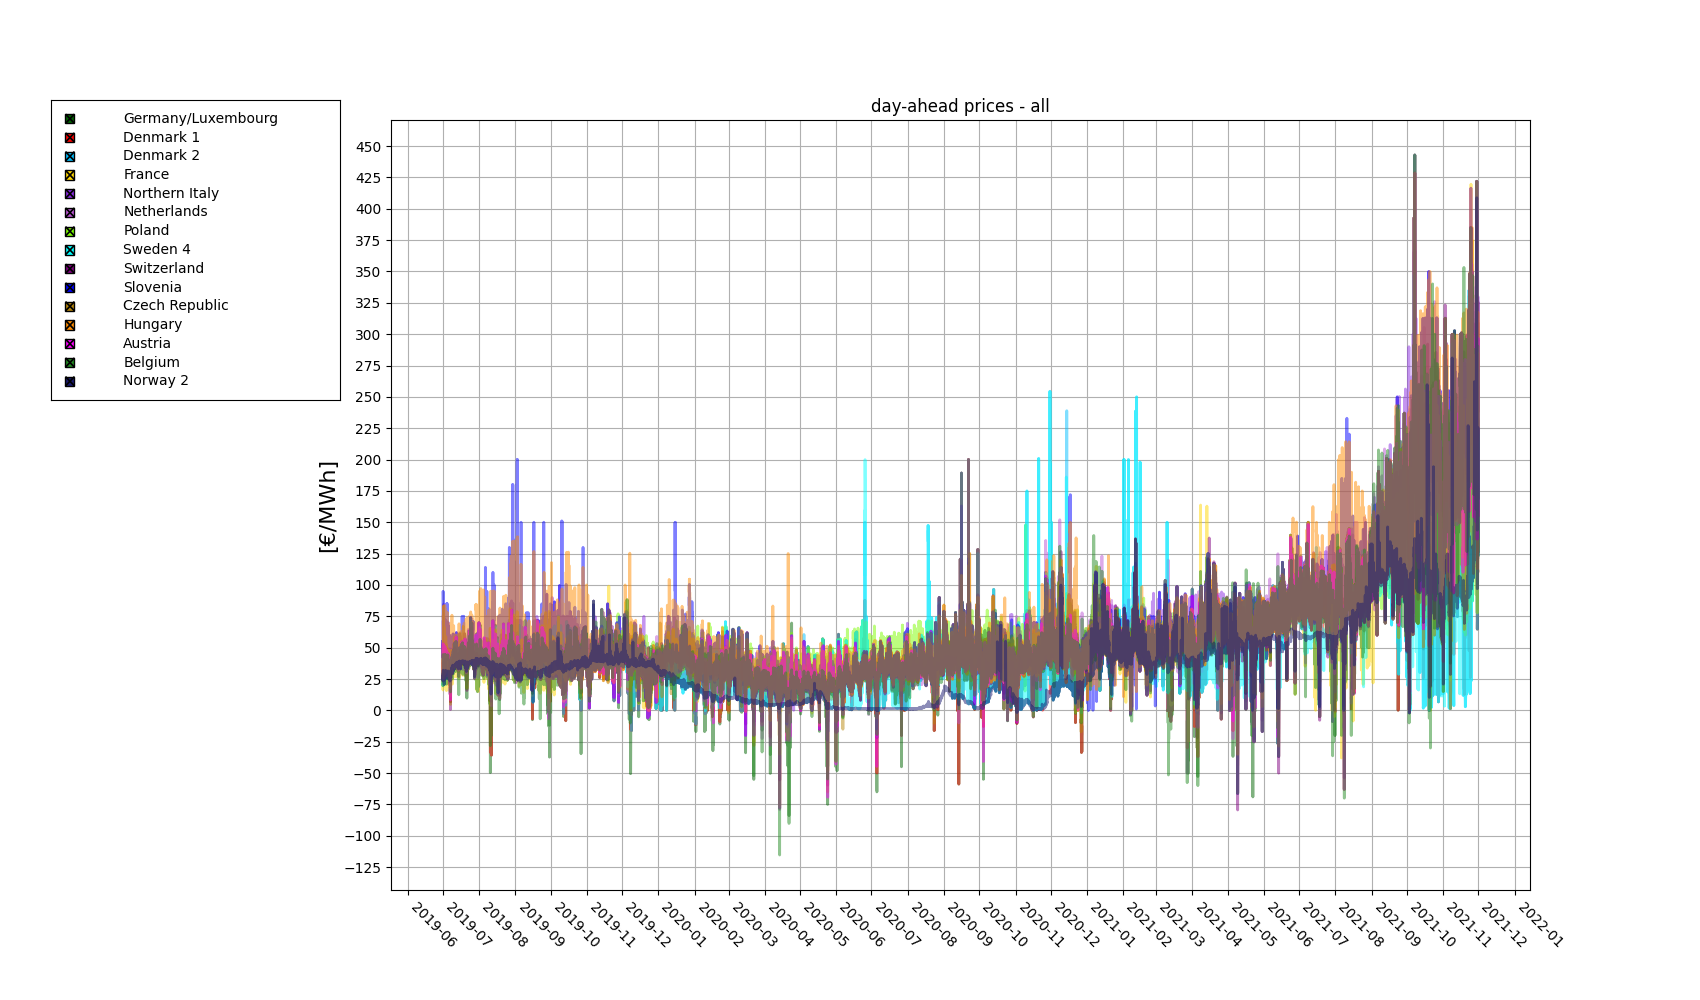

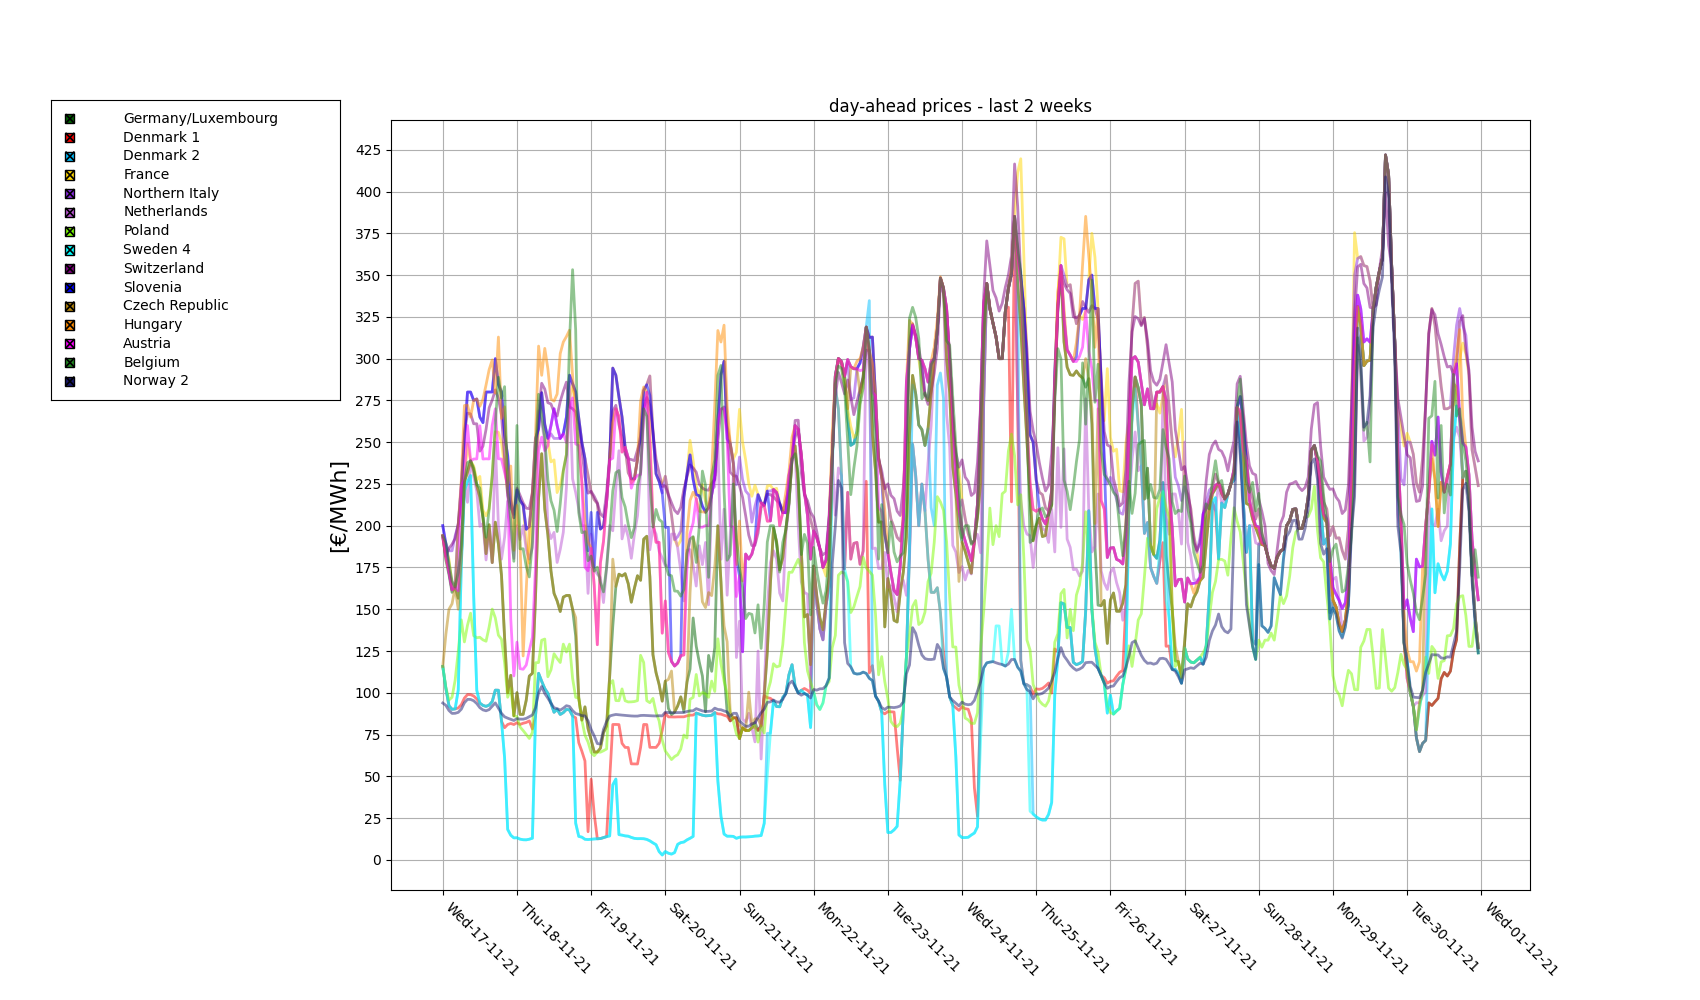

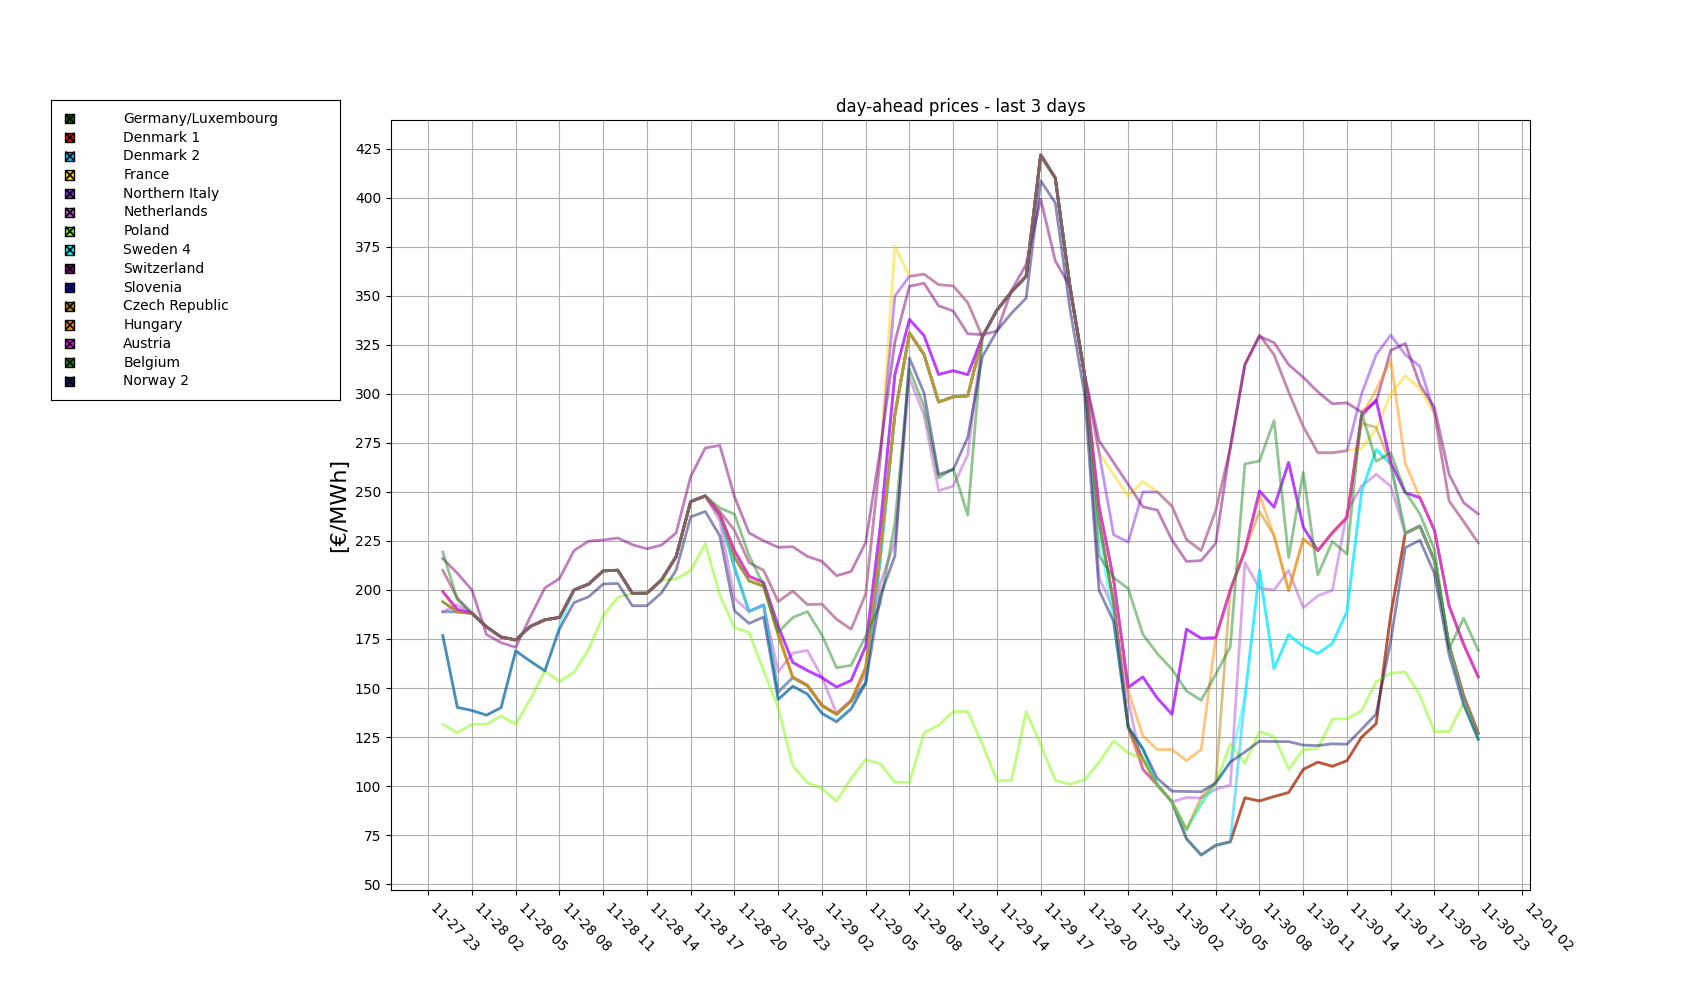

In [12]:
boxes_price_all = draw_line_graph(price_all, "day-ahead prices - all", ex_tick = 'month')
boxes_price_week_2 = draw_line_graph(price_week_2, "day-ahead prices - last 2 weeks", ex_tick = 'day')
boxes_price_days_3 = draw_line_graph(price_days_3, "day-ahead prices - last 3 days", ex_tick = 'hour')

#### GENERATION

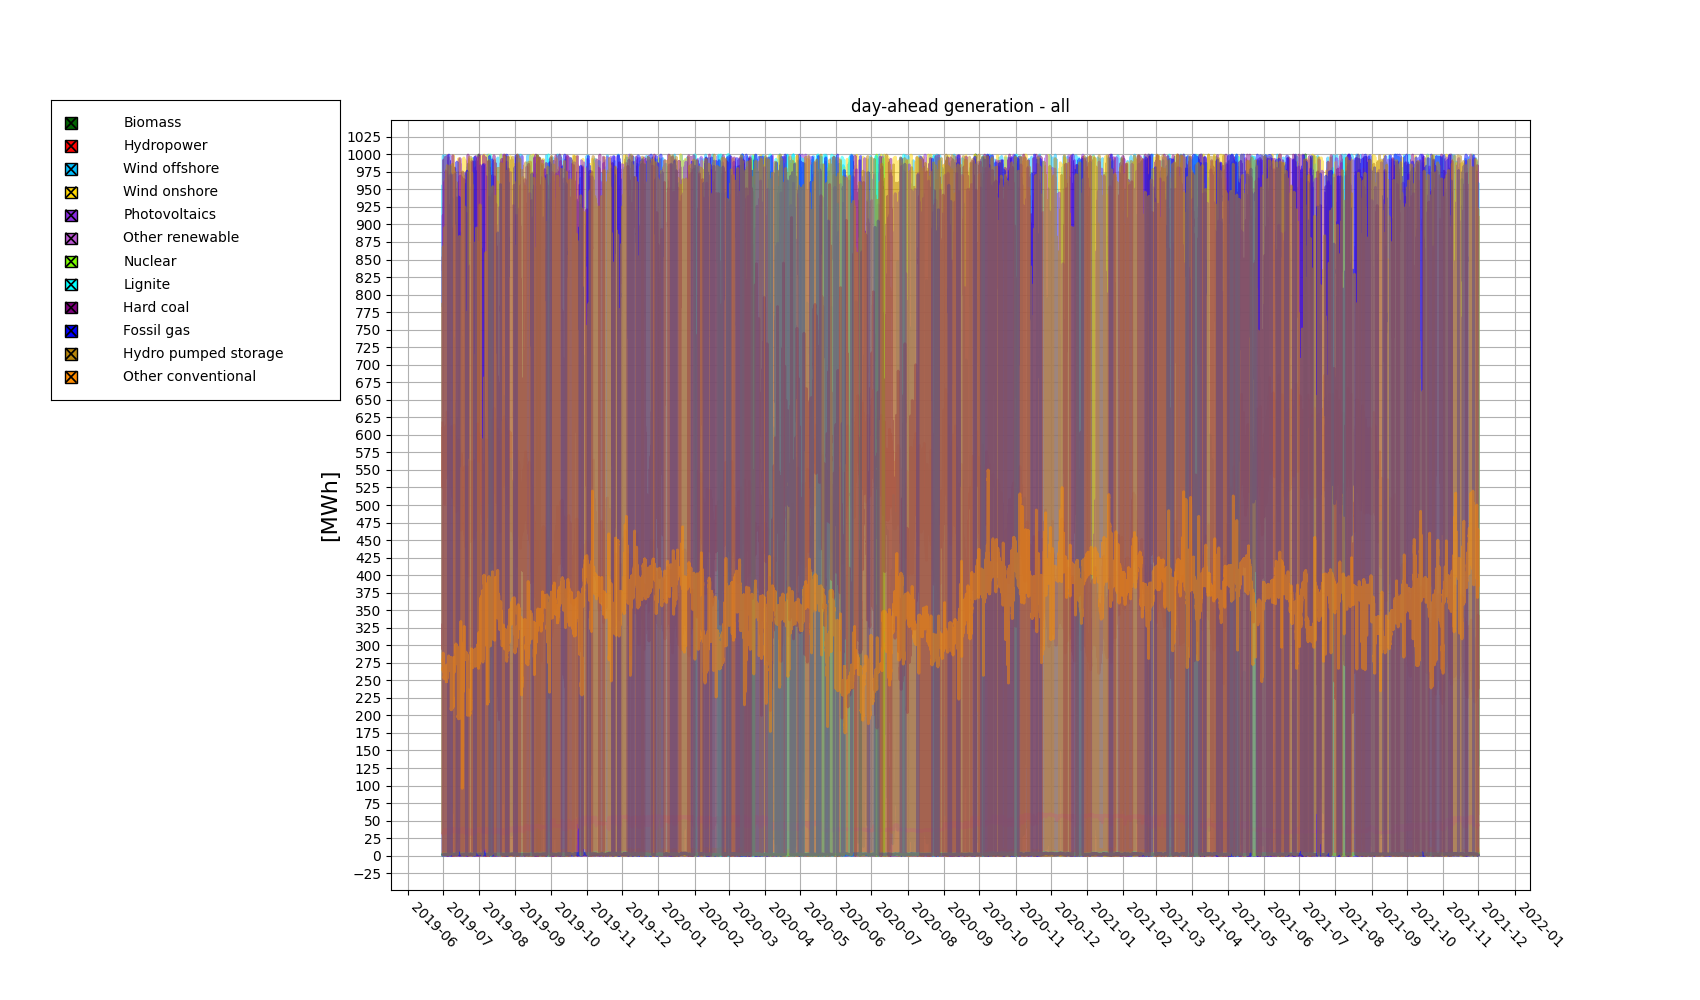

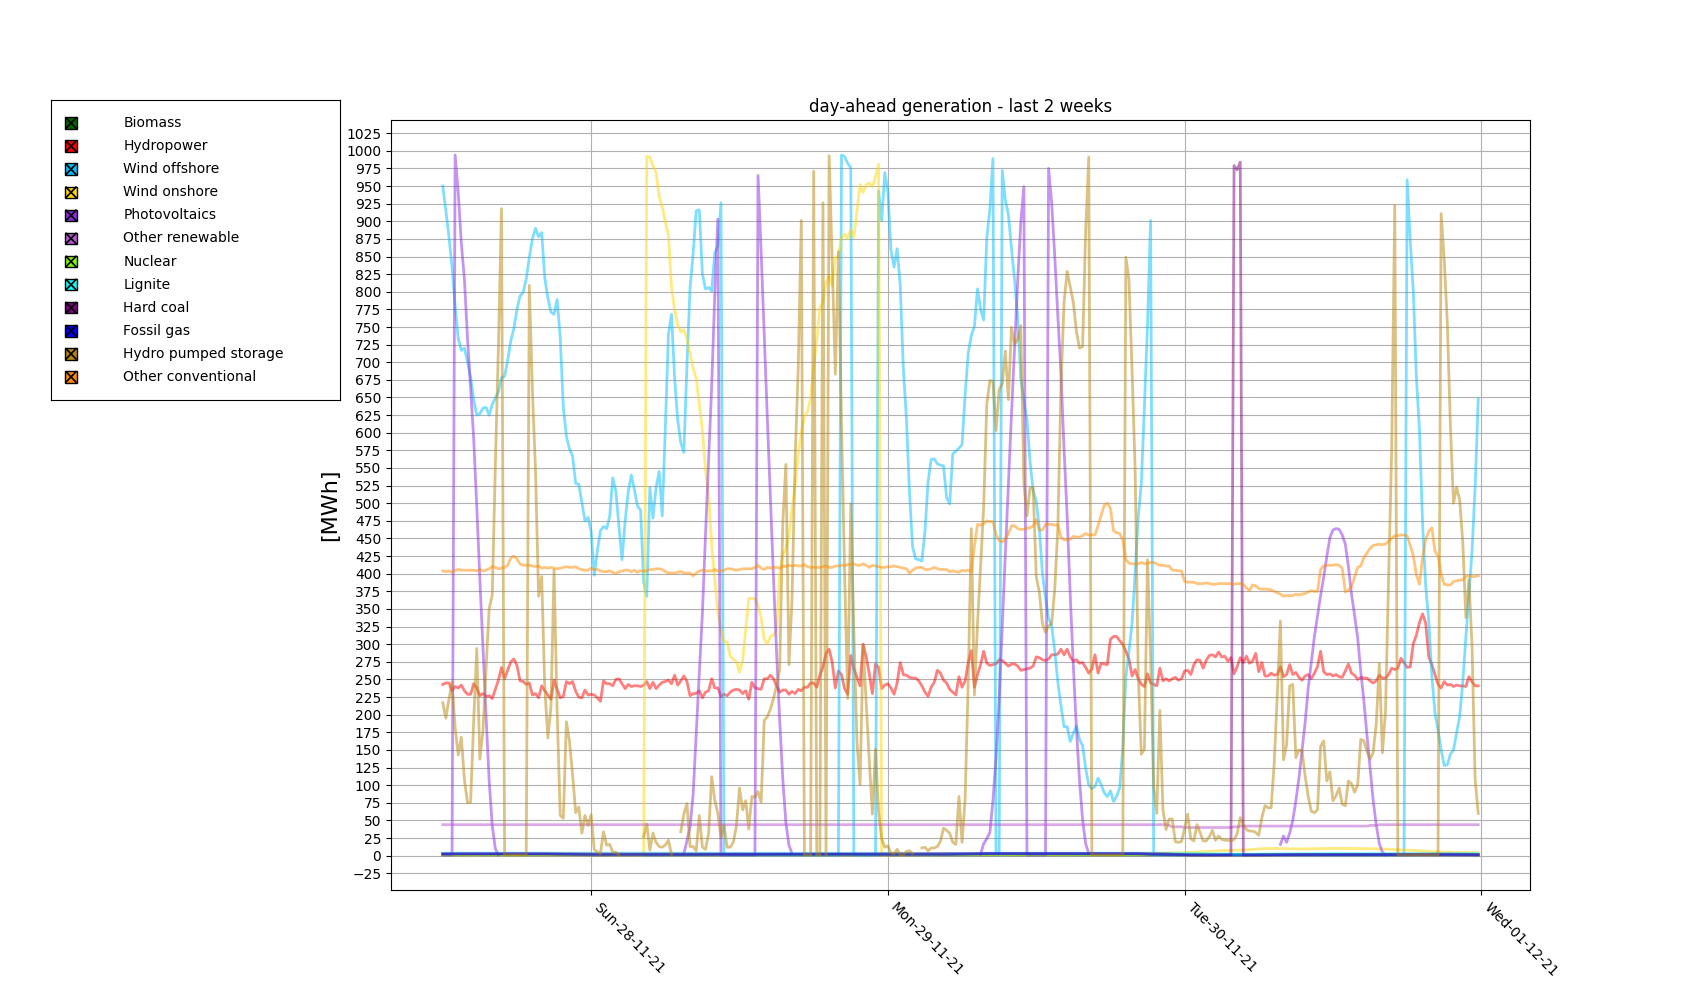

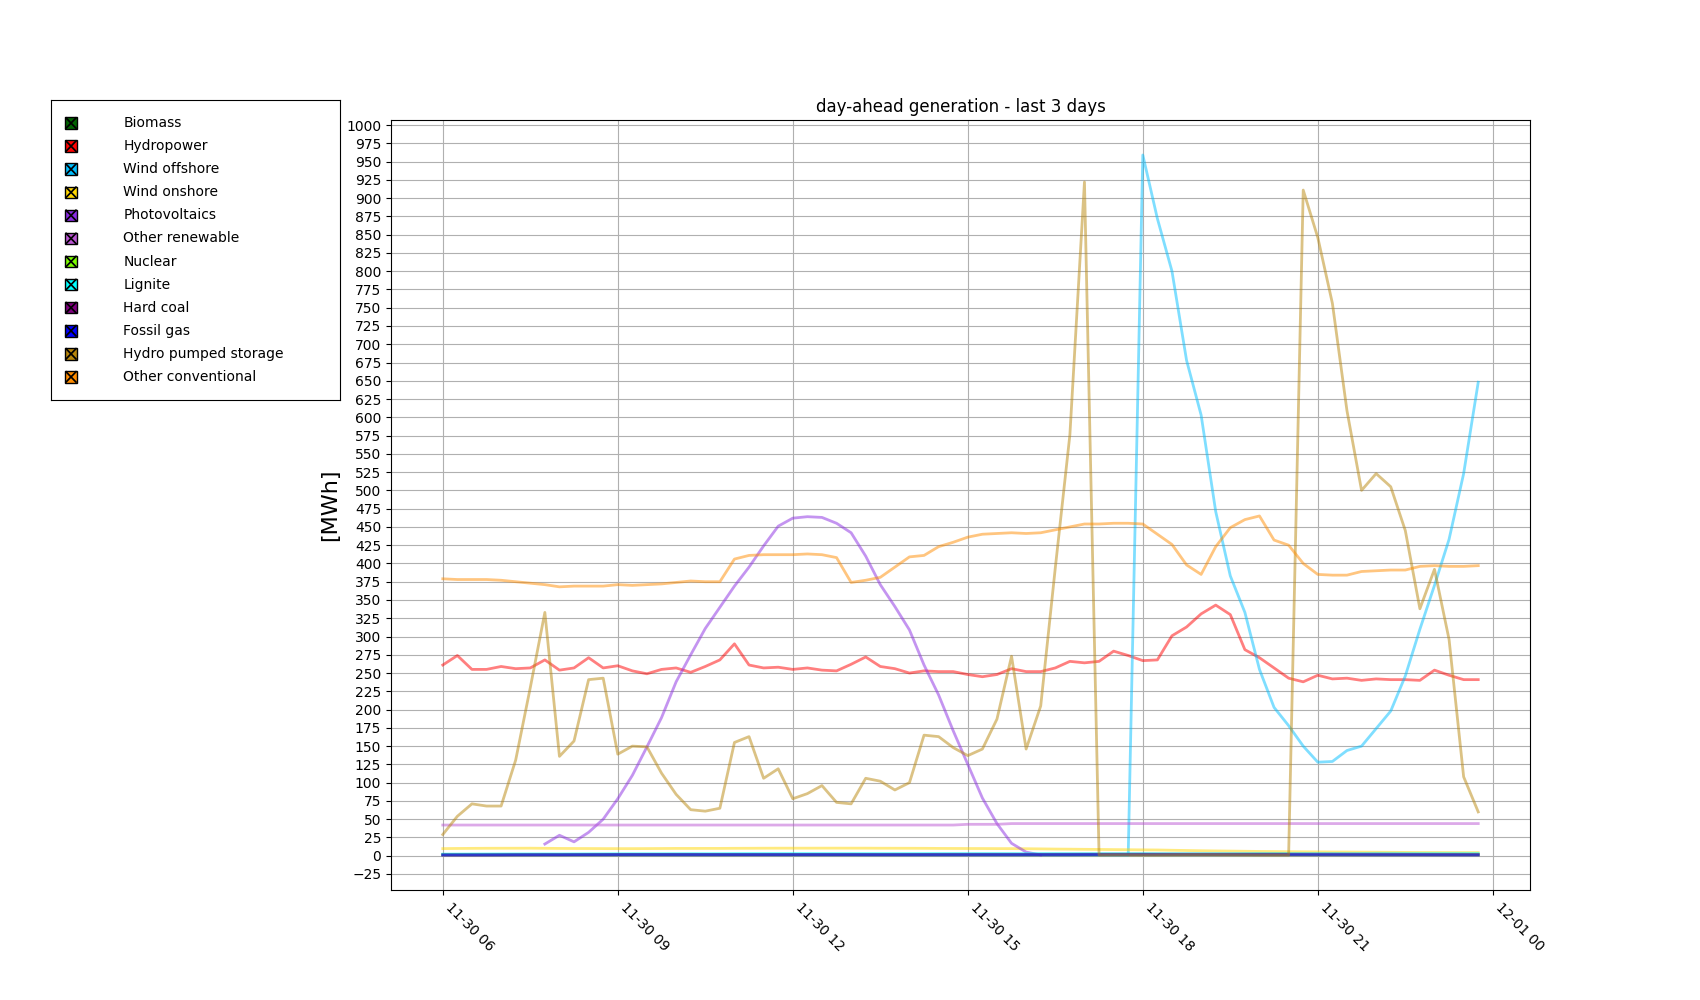

In [13]:
boxes_gener_all = draw_line_graph(gener_all, "day-ahead generation - all", ex_tick = 'month')
boxes_gener_week_2 = draw_line_graph(gener_week_2, "day-ahead generation - last 2 weeks", ex_tick = 'day')
boxes_gener_days_3 = draw_line_graph(gener_days_3, "day-ahead generation - last 3 days", ex_tick = 'hour')

#### CONSUMPTION

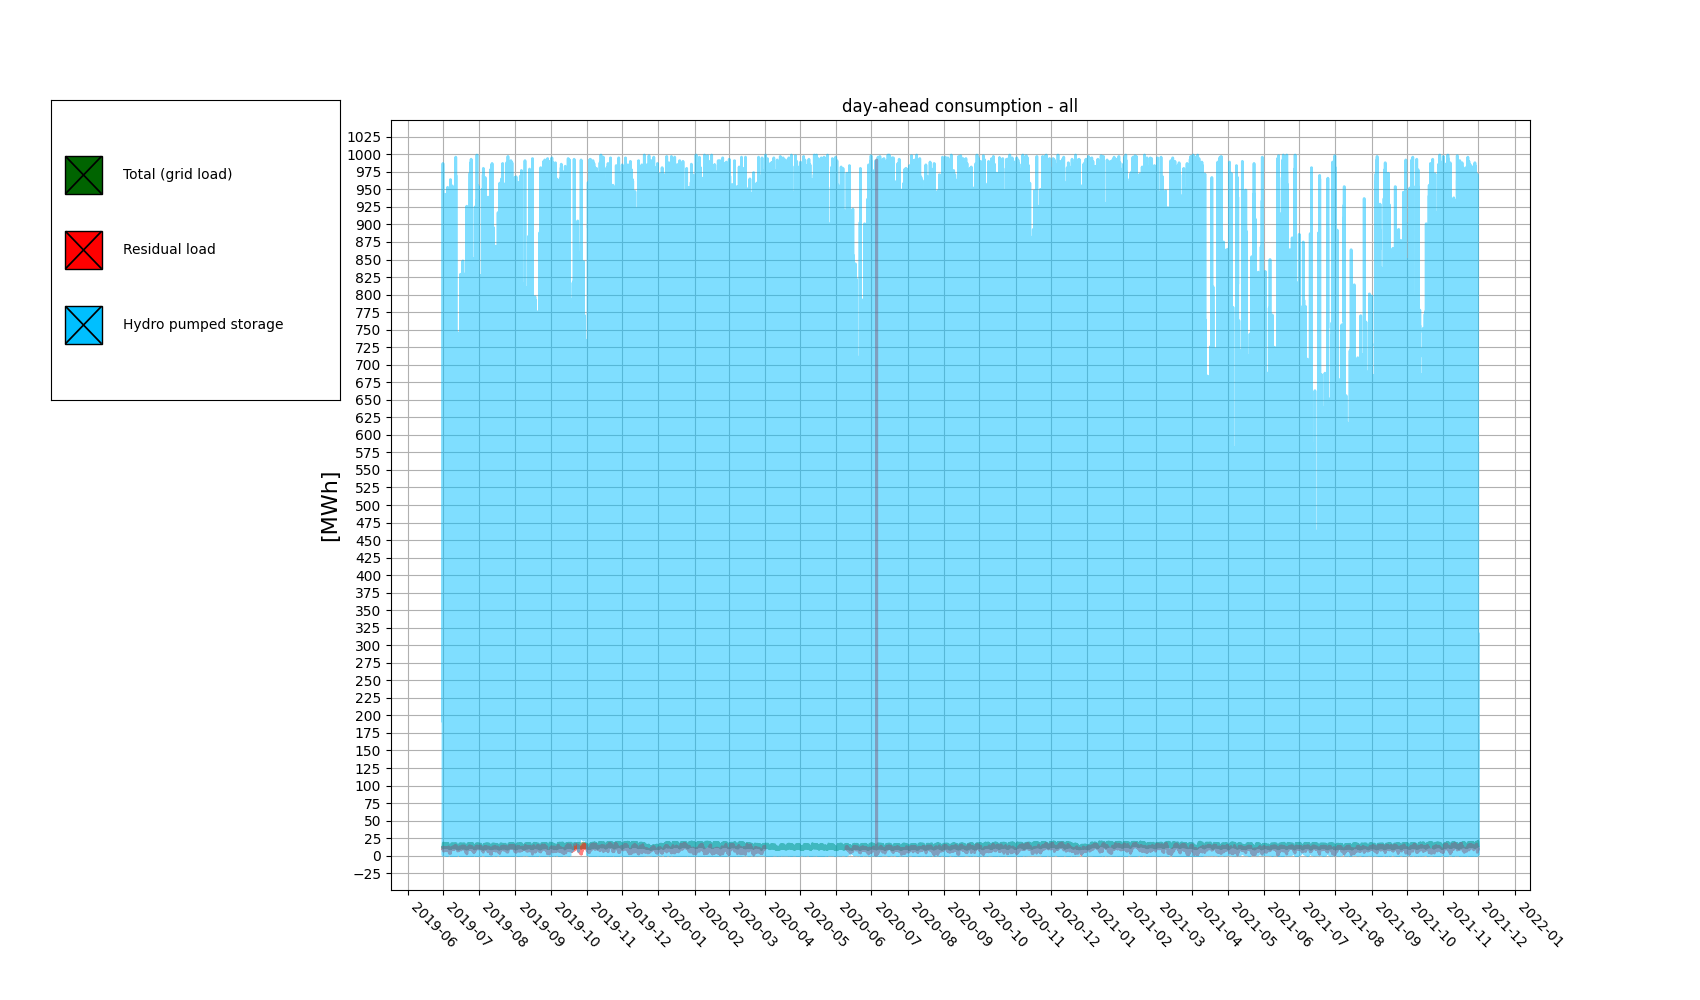

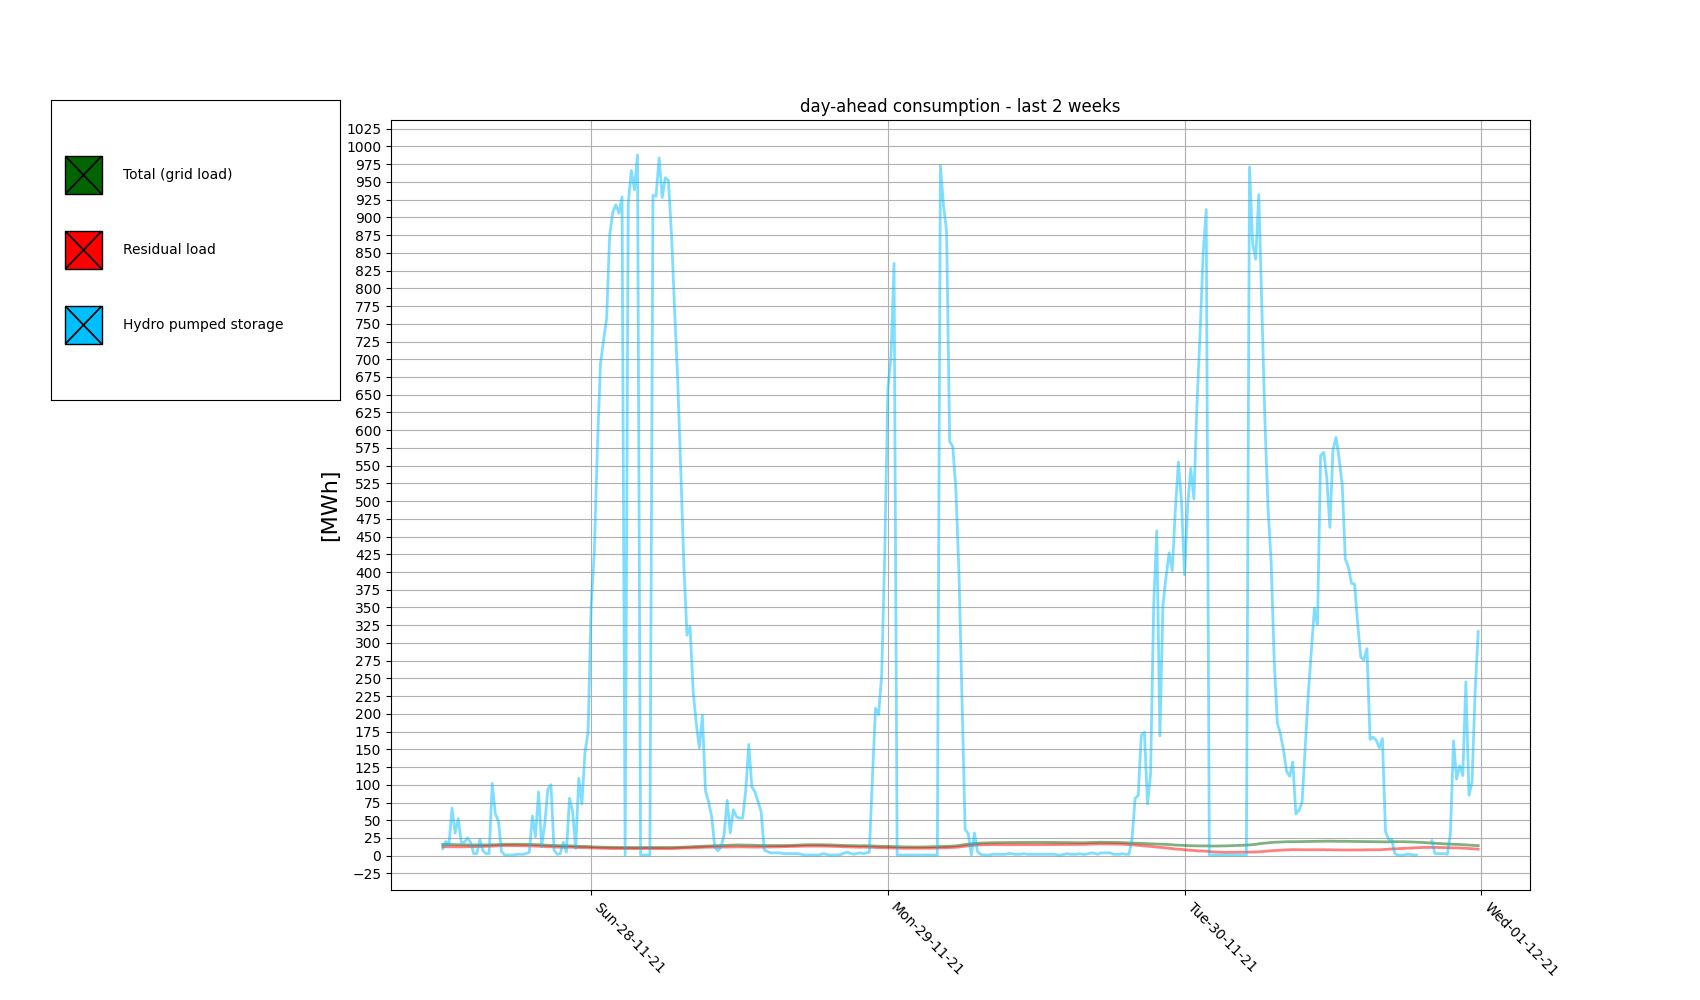

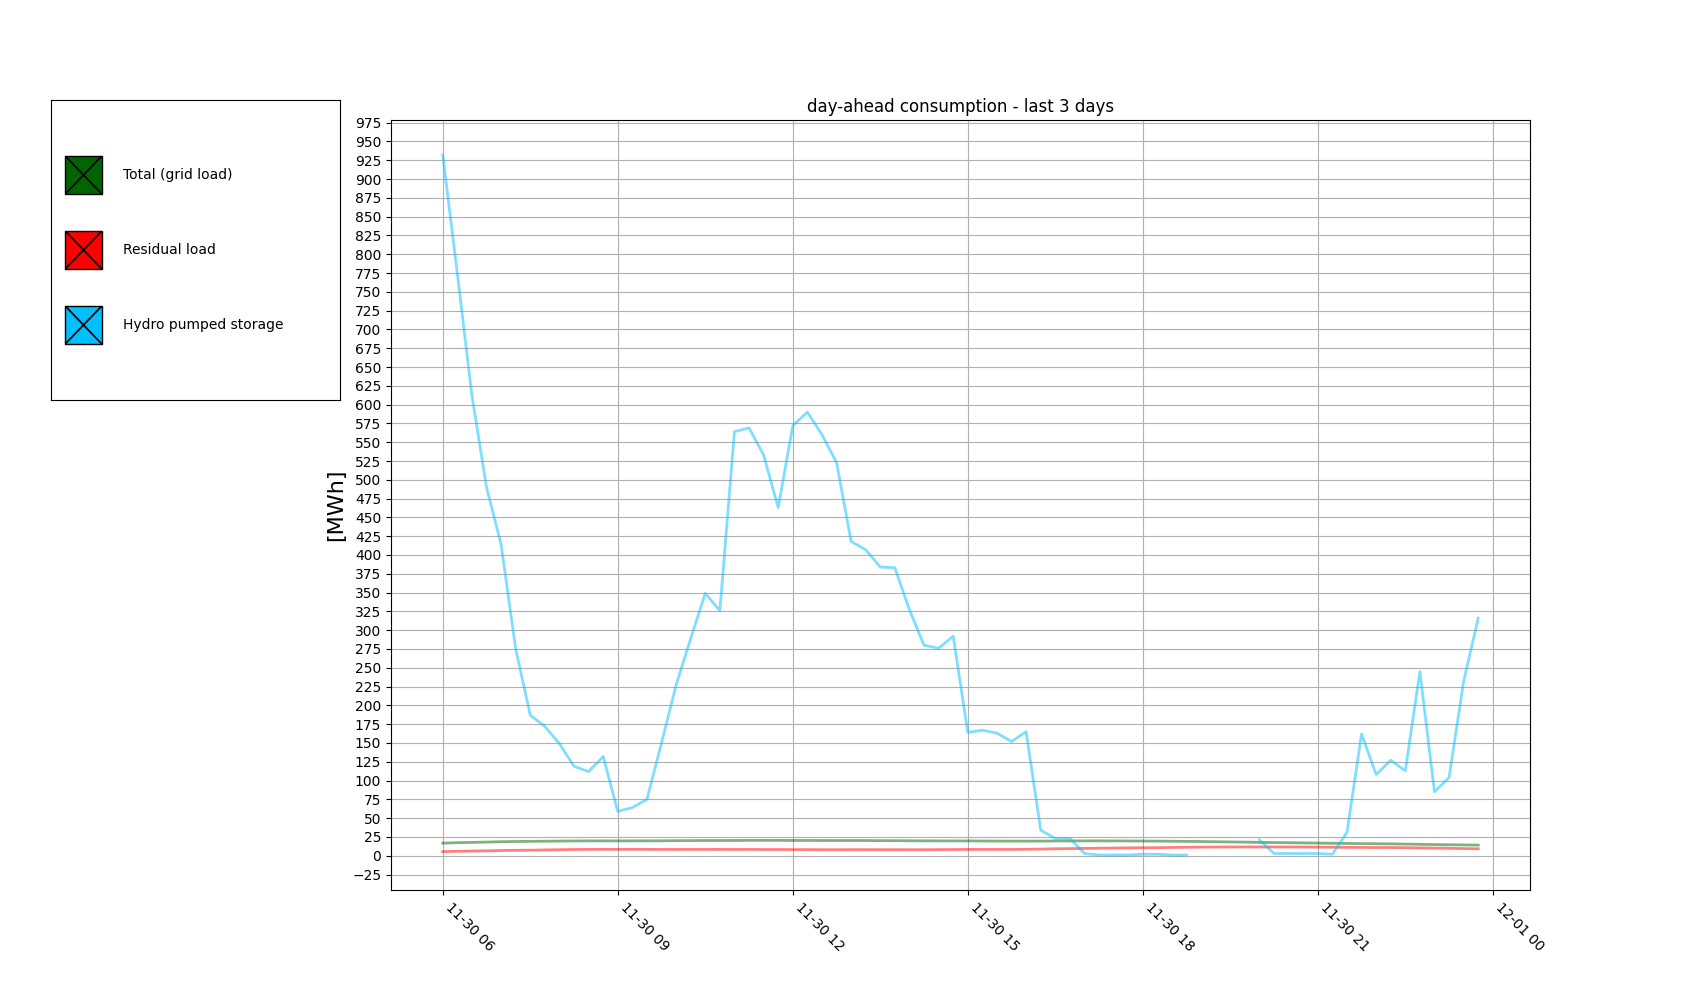

In [14]:
boxes_consu_all = draw_line_graph(consu_all, "day-ahead consumption - all", ex_tick = 'month')
boxes_consu_week_2 = draw_line_graph(consu_week_2, "day-ahead consumption - last 2 weeks", ex_tick = 'day')
boxes_consu_days_3 = draw_line_graph(consu_days_3, "day-ahead consumption - last 3 days", ex_tick = 'hour')

# CROSSCORELATION

#### 1-2-3 DAYS

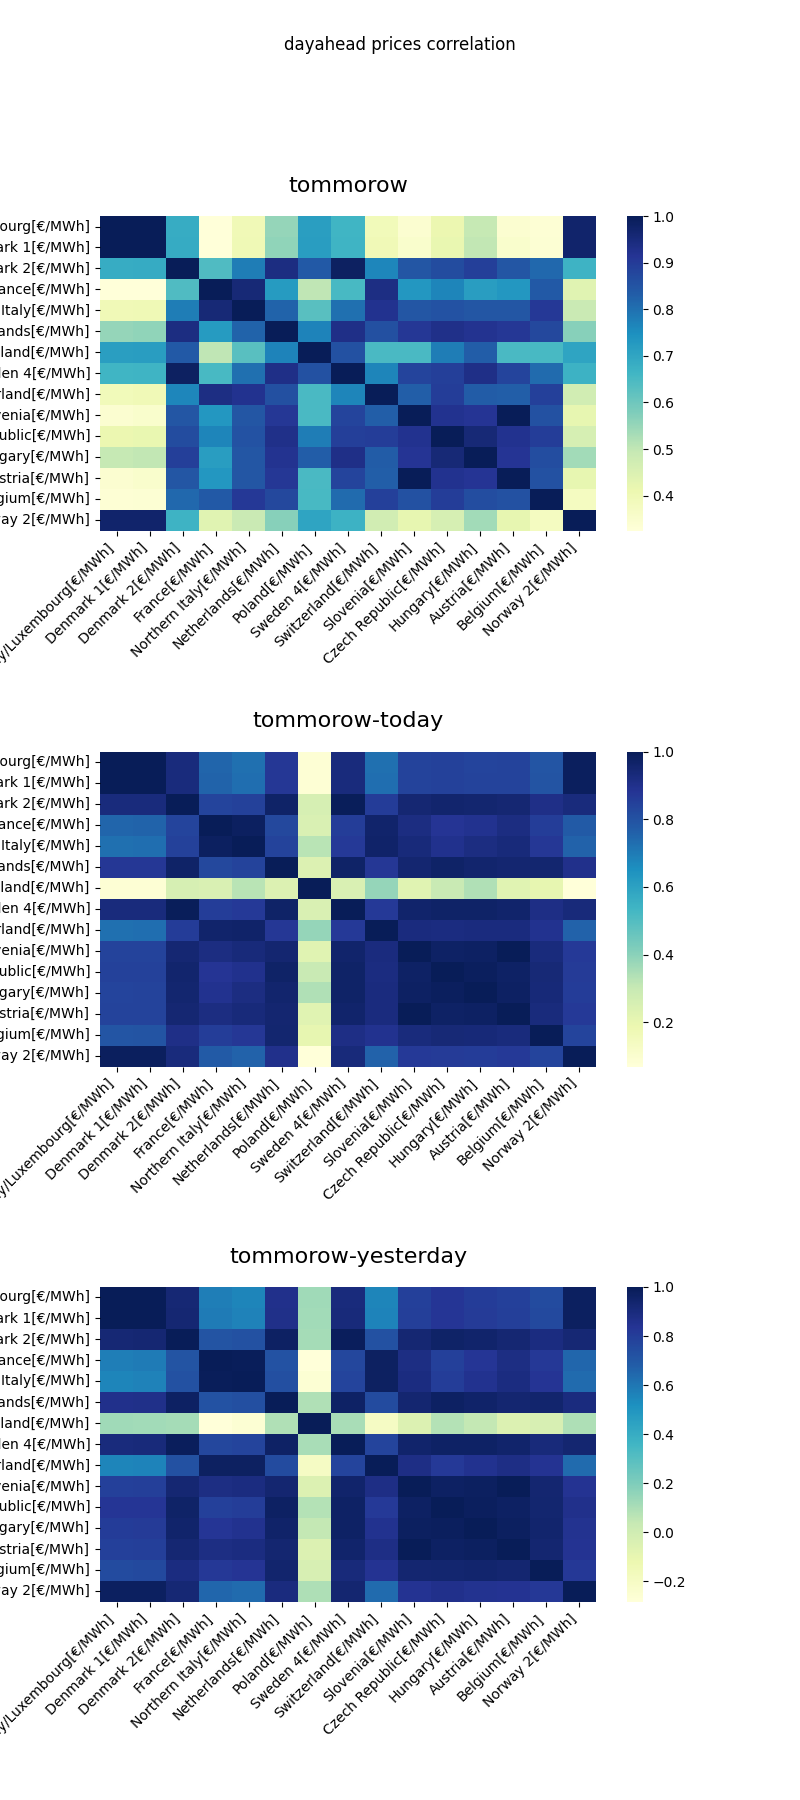

In [15]:
fig, axs = plt.subplots(3, figsize = (8,18));
fig      = plt.subplots_adjust(hspace = 0.7);
plt.suptitle('dayahead prices correlation')

axs[0].set_title('tommorow',           y = 1.05, size = 16)
axs[1].set_title('tommorow-today',     y = 1.05, size = 16)
axs[2].set_title('tommorow-yesterday', y = 1.05, size = 16)

corr = price_days_1.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[0]);
corr = price_days_2.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[1]);
corr = price_days_3.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[2]);

plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45, ha='right');
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45, ha='right');
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45, ha='right');

#### POLAND DAY-AHEAD TO COUNTRIES 1-2-3 DAYS, DAY-TO-DAY

In [16]:
df_Poland_corr = df_corr_3days(price_all)
df_Poland_corr.corr().filter(['Poland tomorrow']).drop(['Poland tomorrow']).sort_values('Poland tomorrow', ascending = False)

Poland tomorrow
Sweden 4 tomorrow                    0.856914
Belgium today                        0.843484
Norway 2 yesterday                   0.842178
Denmark 2 tomorrow                   0.840780
Sweden 4 yesterday                   0.837657
Hungary tomorrow                     0.832449
Netherlands today                    0.829687
Norway 2 today                       0.810892
Poland yesterday                     0.809279
Hungary today                        0.805235
Switzerland yesterday                0.800672
Czech Republic today                 0.785542
Germany/Luxembourg today             0.785542
Denmark 2 today                      0.785143
Denmark 1 today                      0.785143
Sweden 4 today                       0.779557
Czech Republic tomorrow              0.778509
Slovenia today                       0.774342
Austria today                        0.774342
Switzerland today                    0.772419
Netherlands tomorrow                 0.768897
Austria yesterday                    0.768644
Slovenia yesterday                   0.768644
Czech Republic yesterday             0.764071
Germany/Luxembourg yesterday         0.764071
Northern Italy yesterday             0.760407
France yesterday                     0.760407
Hungary yesterday                    0.760223
France today                         0.746867
Northern Italy today                 0.729912
Denmark 1 tomorrow                   0.718522
Germany/Luxembourg tomorrow          0.717348
Norway 2 tomorrow                    0.704102
Belgium yesterday                    0.698176
Netherlands yesterday                0.686490
Denmark 2 yesterday                  0.664905
Denmark 1 yesterday                  0.664905
Belgium tomorrow                     0.654008
Slovenia tomorrow                    0.651282
Austria tomorrow                     0.651282
Switzerland tomorrow                 0.649084
Northern Italy tomorrow              0.627731
France tomorrow                      0.503151
Poland today                         0.292122

In [17]:
df_Poland_corr

Germany/Luxembourg tomorrow  Germany/Luxembourg today  \
0                        113.90                    155.39   
1                        100.51                    151.31   
2                         91.93                    141.13   
3                         73.06                    136.65   
4                         64.82                    143.39   
5                         69.75                    160.51   
6                         71.56                    221.07   
7                         93.97                    289.44   
8                         92.39                    331.14   
9                         94.65                    320.09   
10                        96.68                    295.83   
11                       108.44                    298.54   
12                       112.19                    299.03   
13                       110.05                    329.20   
14                       112.95                    342.77   
15                       124.91                    352.11   
16                       131.80                    360.00   
17                       187.28                    421.87   
18                       228.92                    410.13   
19                       232.60                    355.06   
20                       215.06                    310.16   
21                       171.89                    234.68   
22                       145.89                    193.53   
23                       126.94                    130.05   

    Germany/Luxembourg yesterday  Denmark 1 tomorrow  Denmark 1 today  \
0                         193.95              108.59           155.39   
1                         188.88              100.51           151.31   
2                         188.12               91.93           141.13   
3                         181.20               73.06           136.65   
4                         176.00               64.82           143.39   
5                         174.50               69.75           152.60   
6                         181.40               71.56           215.76   
7                         184.77               93.97           289.44   
8                         185.99               92.39           331.14   
9                         199.99               94.65           320.09   
10                        203.01               96.68           295.83   
11                        209.76              108.44           298.54   
12                        210.07              112.19           299.03   
13                        198.28              110.05           329.20   
14                        198.34              112.95           342.77   
15                        205.11              124.91           352.11   
16                        217.03              131.80           360.00   
17                        245.13              187.28           421.87   
18                        247.94              228.92           410.13   
19                        238.15              232.60           355.06   
20                        216.63              215.06           310.16   
21                        204.69              171.89           234.68   
22                        201.80              145.89           193.53   
23                        177.24              126.94           130.05   

    Denmark 1 yesterday  Denmark 2 tomorrow  Denmark 2 today  \
0                188.89              119.03           155.39   
1                188.88              100.51           151.31   
2                188.12               91.93           141.13   
3                181.20               73.06           136.65   
4                176.00               64.82           143.39   
5                174.50               69.75           152.60   
6                181.40               71.56           215.76   
7                184.77              144.98           289.44   
8                185.99              210.04           331.14   
9           

#### CROSSCORRELATION POLAND TO COUNTRIES WHOLE PERIOD

In [21]:
price_all.corr().filter(['Poland[€/MWh]']).drop(['Poland[€/MWh]']).sort_values(['Poland[€/MWh]'], ascending = False)

Poland[€/MWh]
Czech Republic[€/MWh]           0.913042
Germany/Luxembourg[€/MWh]       0.896779
Austria[€/MWh]                  0.885075
Netherlands[€/MWh]              0.869623
Hungary[€/MWh]                  0.867044
Denmark 1[€/MWh]                0.866071
Belgium[€/MWh]                  0.864287
Slovenia[€/MWh]                 0.862632
France[€/MWh]                   0.859875
Northern Italy[€/MWh]           0.857959
Denmark 2[€/MWh]                0.854794
Switzerland[€/MWh]              0.852054
Sweden 4[€/MWh]                 0.832913
Norway 2[€/MWh]                 0.794988

# MODELE

In [18]:
#CENY ZNORMALIZOWANE W ZAKRESIE 0-100
makro = 15; #najlepszy wynik dla 15 tygodni (ręczny dobór)
[train_x,train_y,train_time] = generate_df_weeks(price_all,gener_all,consu_all,weeks=makro,drop_latest_weeks=2,drop_earliest_weeks=0) #całość bez 2 ostatnich tygodni
[valid_x,valid_y,valid_time] = generate_df_weeks(price_all,gener_all,consu_all,weeks=makro,drop_latest_weeks=1,drop_earliest_weeks=makro-2) #przedostatni tydzień
[test_x,test_y,test_time]    = generate_df_weeks(price_all,gener_all,consu_all,weeks=makro,drop_latest_weeks=0,drop_earliest_weeks=makro-1) #ostatni tydzień

In [23]:
train_x

Czech Republic[€/MWh]  Austria[€/MWh]  consu. total (grid load)[MWh]  \
0                  0.141430        0.145525                         45.588   
1                  0.144254        0.148312                         44.810   
2                  0.147637        0.147383                         45.072   
3                  0.146587        0.150611                         46.377   
4                  0.153634        0.154582                         49.576   
...                     ...             ...                            ...   
2179               0.651243        0.652887                         67.758   
2180               0.583339        0.585304                         63.900   
2181               0.487061        0.496052                         60.692   
2182               0.419531        0.431256                         57.511   
2183               0.330837        0.399601                         54.094   

      gener. total[MWh]  Poland -1 day  Germany/Luxembourg -1 day  \
0              7588.724       0.166001                   0.116763   
1              7571.660       0.166632                   0.094309   
2              7489.279       0.167094                   0.037063   
3              7723.086       0.168145                   0.080689   
4              8013.816       0.164824                   0.117055   
...                 ...            ...                        ...   
2179           6982.718       0.439615                   0.617167   
2180           6086.729       0.333263                   0.541176   
2181           5332.203       0.328681                   0.494044   
2182           5608.787       0.405524                   0.442169   
2183           6527.281       0.297743                   0.405826   

      Czech Republic -1 day  Austria -1 day  Poland -2 days  \
0                  0.148407        0.120651        0.171970   
1                  0.098005        0.097450        0.166337   
2                  0.033742        0.038297        0.165875   
3                  0.081904        0.083376        0.165707   
4                  0.116789        0.120953        0.184707   
...                     ...             ...             ...   
2179               0.636005        0.637721        0.511119   
2180               0.557111        0.559199        0.449073   
2181               0.508179        0.510497        0.358821   
2182               0.454323        0.457313        0.306444   
2183               0.416591        0.420317        0.332296   

      Germany/Luxembourg -2 days  ...  Hour_14  Hour_15  Hour_16  Hour_17  \
0                       0.150701  ...        0        0        0        0   
1                       0.144071  ...        0        0        0        0   
2                       0.139688  ...        0        0        0        0   
3                       0.141239  ...        0        0        0        0   
4                       0.157511  ...        0        0        0        0   
...                          ...  ...      ...      ...      ...      ...   
2179                    0.468017  ...        0        0        0        0   
2180                    0.432954  ...        0        0        0        0   
2181                    0.383664  ...        0        0        0        0   
2182                    0.393779  ...        0        0        0        0   
2183                    0.362267  ...        0        0        0        0   

      Hour_18  Hour_19  Hour_20  Hour_21  Hour_22  Hour_23  
0           0        0        0        0        0        0  
1           0        0        0        0        0        0  
2           0        0        0        0        0        0  
3           0        0        0        0        0        0  
4           0        0        0        0        0        0  
...       ...      ...      ...      ...      ...      ...  
2179        0        1        0        0        0        0  
2180        0        0        1        0        0        0  
2181     

# REGRESJA LINIOWA I GRZBIETOWA

In [24]:
train_x.columns

Index(['Czech Republic[€/MWh]', 'Austria[€/MWh]',
       'consu. total (grid load)[MWh]', 'gener. total[MWh]', 'Poland -1 day',
       'Germany/Luxembourg -1 day', 'Czech Republic -1 day', 'Austria -1 day',
       'Poland -2 days', 'Germany/Luxembourg -2 days', 'Poland -7 days',
       'Germany/Luxembourg -7 days', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [19]:
lr_model = LinearRegression().fit(train_x,train_y)
r_model = Ridge(alpha = 1.0).fit(train_x,train_y)
predict_lr = lr_model.predict(test_x)
predict_r = r_model.predict(test_x)
#type(predict_lr)
#type(test_y)
#lr_model.score(test_y, predict_lr)
#lr_model.score(test_y, predict_lr)

In [20]:
print("REGRESJA LINIOWA")
print("score =",lr_model.score(train_x, train_y))
print("średni błąd absolutny =",mean_absolute_error(test_y, predict_lr))
print("średni błąd kwadratowy =",mean_squared_error(test_y, predict_lr))

REGRESJA LINIOWA
score = 0.7785891657814882
średni błąd absolutny = 38.97376057630033
średni błąd kwadratowy = 2044.6375006677522


In [21]:
print("REGRESJA GRZBIETOWA")
print("score =",r_model.score(train_x, train_y))
print("średni błąd absolutny =",mean_absolute_error(test_y, predict_r))
print("średni błąd kwadratowy =",mean_squared_error(test_y, predict_r))

REGRESJA GRZBIETOWA
score = 0.7770254087976259
średni błąd absolutny = 39.1891260796148
średni błąd kwadratowy = 2078.930046426511


In [22]:
def compare_plot(x,y0, *predicted):
    fig, ax = plt.subplots(figsize=(17,10))
    ax.plot(x, y0[0],label=y0[1])
    
    for predict in predicted:
        ax.plot(x, predict[0],label=predict[1])
    
    #Wygląd wykresu
    ax.legend(loc="upper right")
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha='left');
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, ha='right');
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1));
    
    ax.set_title("actual prices vs predicted",fontsize = 25);
    ax.set_xlabel("time",fontsize = 16);
    ax.set_ylabel("[[€/MWh]]",fontsize = 16,rotation=0,ha='right');
    
    ax.grid()

    plt.show()

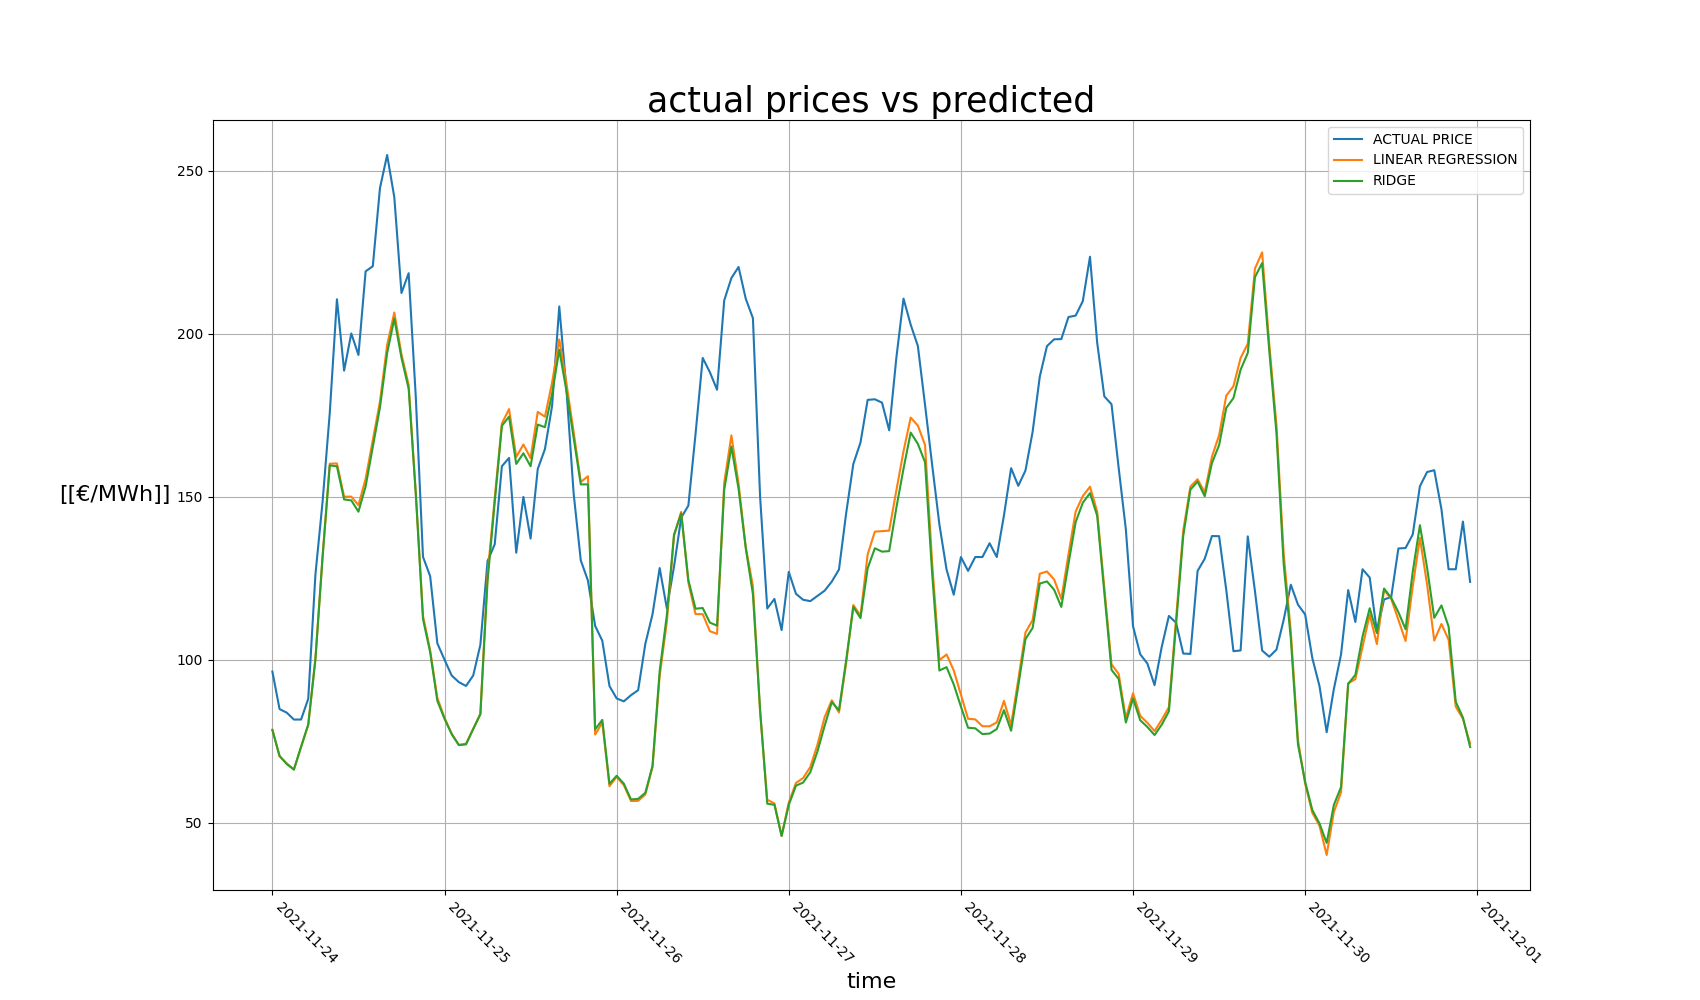

In [23]:
compare_plot(test_time,[test_y,"ACTUAL PRICE"],[predict_lr,"LINEAR REGRESSION"],[predict_r,"RIDGE"])

# DODATKOWE HOLT WINTERS I ARIMA

## HOLT WINTERS

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
hw_model=ExponentialSmoothing(endog = train_y, seasonal='add', seasonal_periods=24).fit()
len(predict_lr)

168

In [26]:
predict_hw = hw_model.forecast(steps = 168) # 168 = 7*24
predict_hw

2184    118.806617
2185    111.959324
2186    105.910983
2187    106.070078
2188    106.035675
           ...    
2347    146.414997
2348    129.143890
2349    116.763364
2350    127.501507
2351    115.842661
Length: 168, dtype: float64

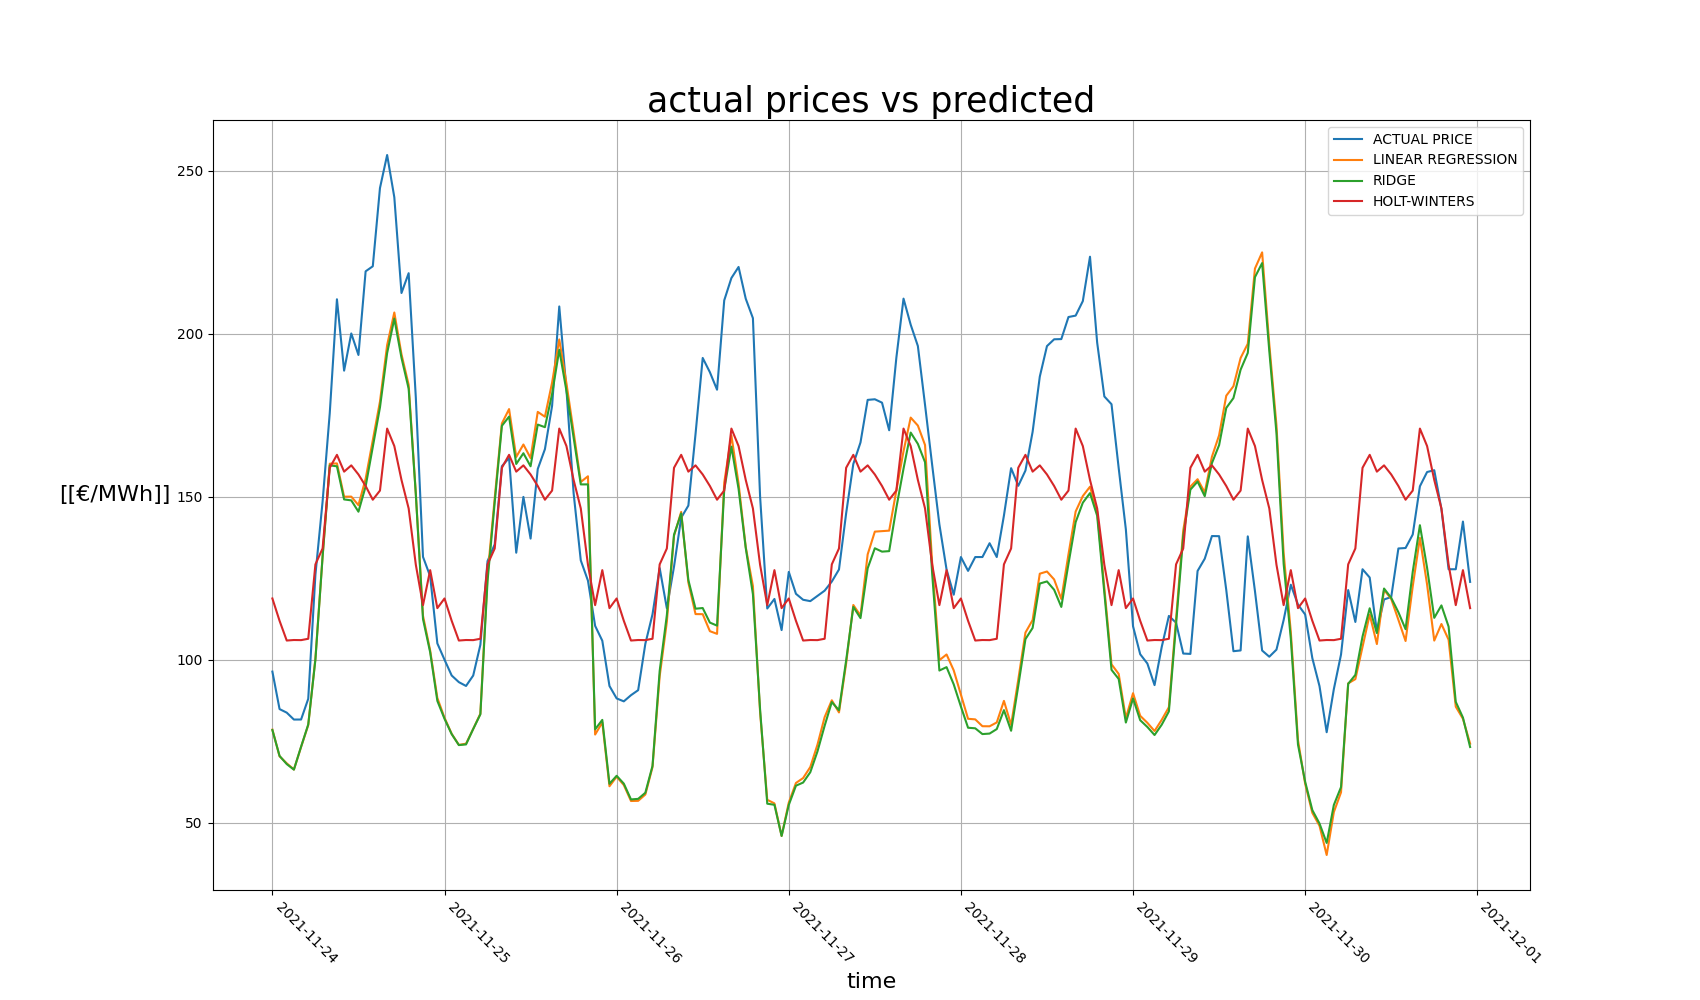

In [27]:
compare_plot(test_time,[test_y,"ACTUAL PRICE"],[predict_lr,"LINEAR REGRESSION"],[predict_r,"RIDGE"],[predict_hw,"HOLT-WINTERS"])

## ARIMA

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

### CHECK IF STATIONARY

C:\Users\wojte\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


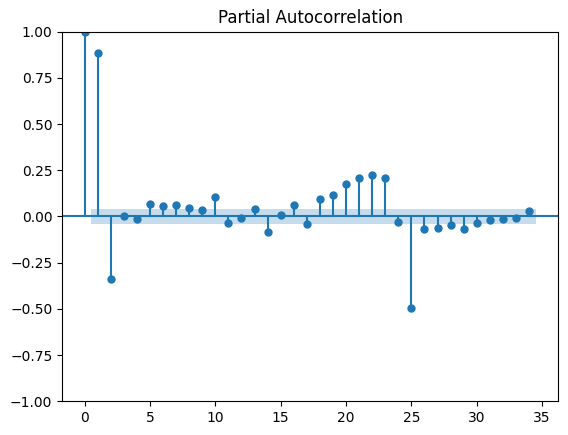

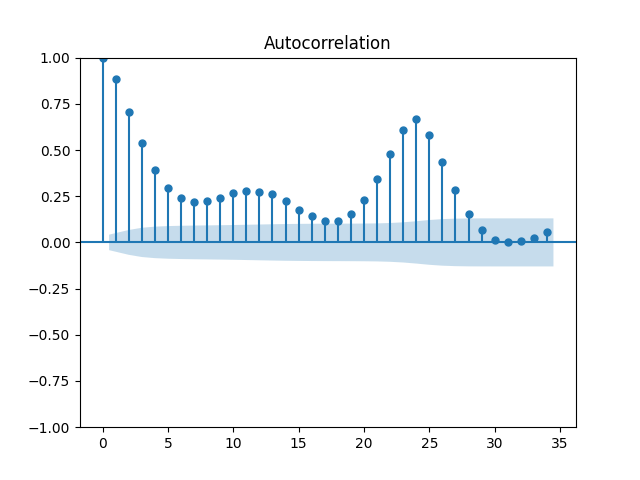

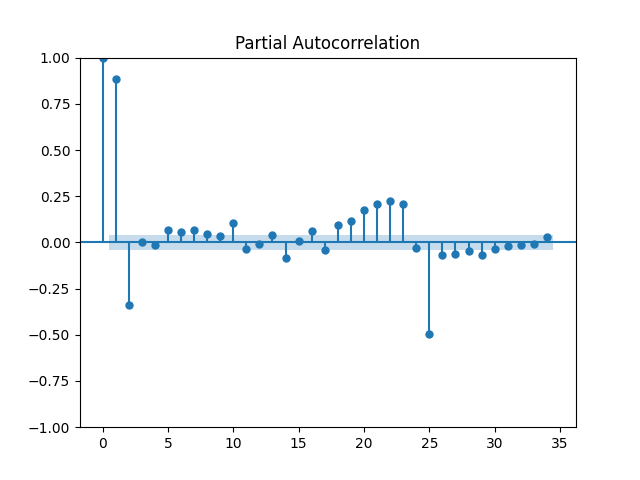

In [29]:
plot_acf(train_y)
plot_pacf(train_y)

In [30]:
print("P-value: ",adfuller(train_y,autolag='AIC')[1])

P-value:  2.4781901275266524e-05


10^-5 STATIONARY

### STATIONARY -> MODEL FIT

In [31]:
auto_arima = pm.auto_arima(train_y, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

In [32]:
model_ARIMA = ARIMA(train_y, order=(4,1,1))
model_ARIMA = model_ARIMA.fit()
predict_ARIMA = model_ARIMA.forecast(len(test_y))

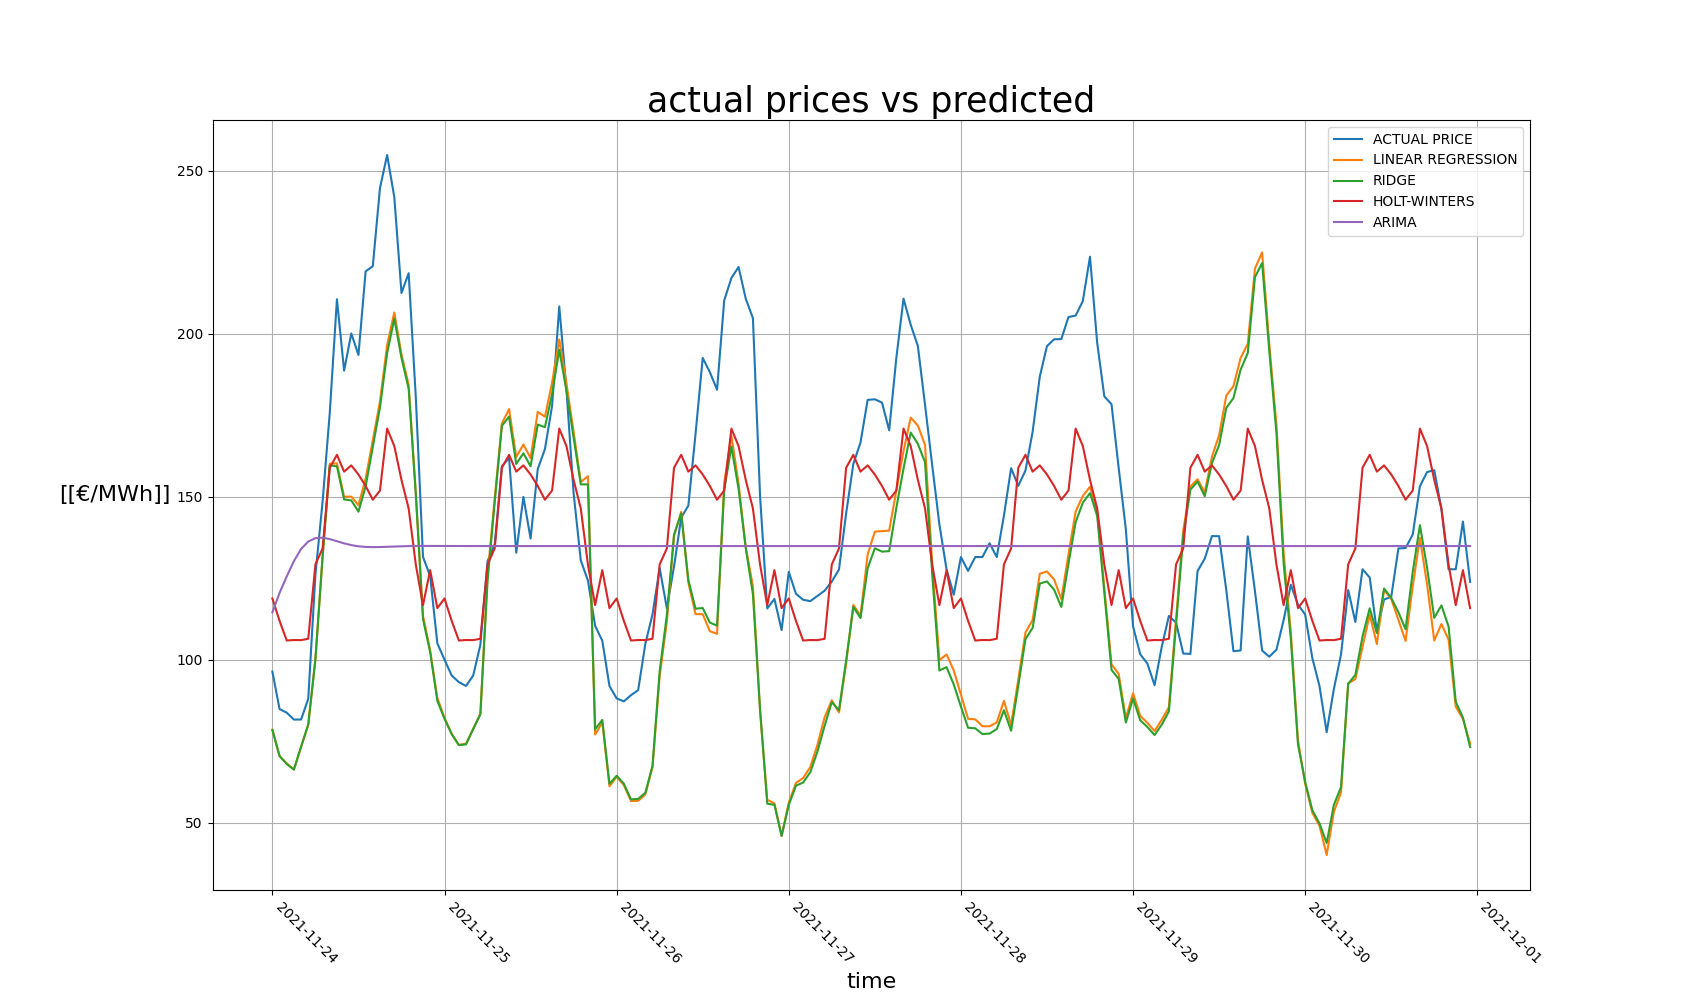

In [33]:
compare_plot(test_time,[test_y,"ACTUAL PRICE"],[predict_lr,"LINEAR REGRESSION"],[predict_r,"RIDGE"],[predict_hw,"HOLT-WINTERS"],[predict_ARIMA,"ARIMA"])

In [34]:
full_time = pd.concat([train_time, valid_time, test_time], ignore_index=True, sort=False)
full_y = pd.concat([train_y, valid_y, test_y], ignore_index=True, sort=False)
compare_df = pd.concat([full_time, full_y], axis=1,sort=False)

predict_ARIMA.name = 'Outcome_autoARIMA'
#forecast_test_auto.reset_index(drop=True, inplace=True)
#compare_outcome = pd.concat([test_time, forecast_test_auto], axis=1,sort=False)
#compare_outcome.index +=2352

compare_df = pd.concat([compare_df, predict_ARIMA], axis=1).set_index('Date')

<AxesSubplot:xlabel='Date'>

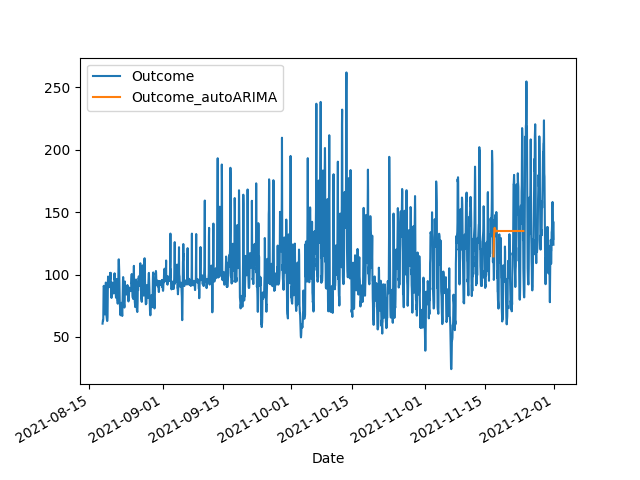

In [35]:
compare_df.plot()

## SARIMAX

In [37]:
SARIMAXmodel = pm.auto_arima(y = train_y,
                             X = train_x,
                             m = 7)

In [39]:
predict_SMX = pd.Series(SARIMAXmodel.predict(n_periods = 168,
                                      X = test_x))

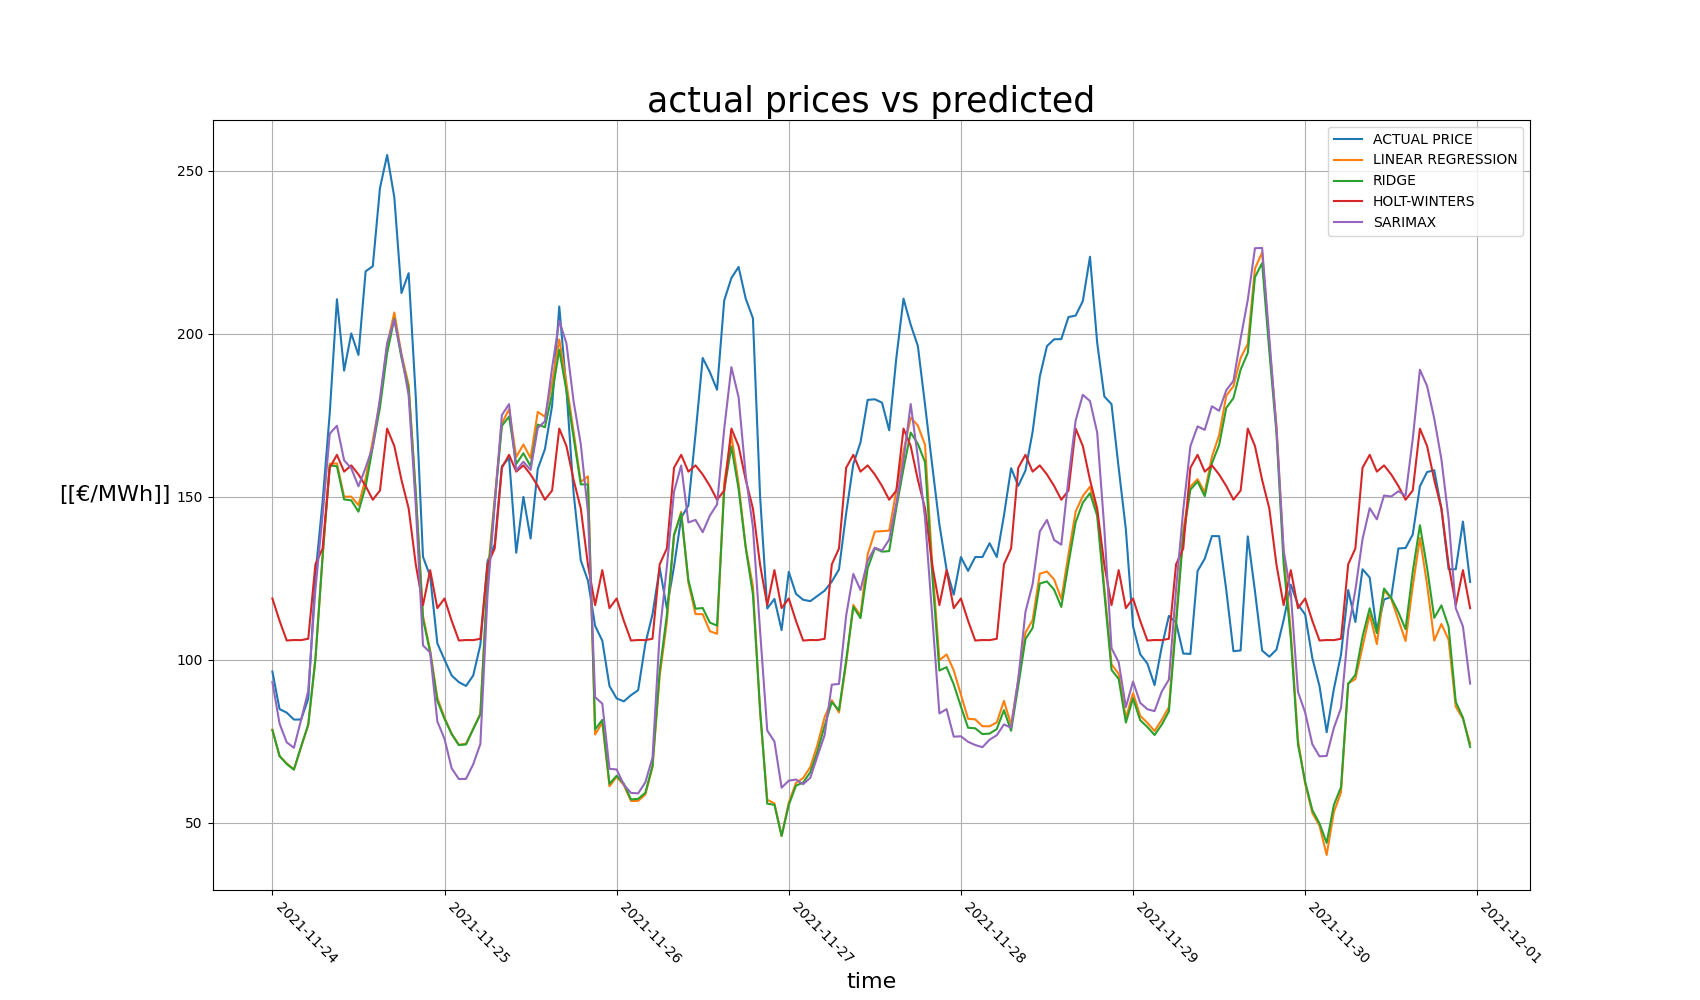

In [40]:
compare_plot(test_time,[test_y,"ACTUAL PRICE"],[predict_lr,"LINEAR REGRESSION"],[predict_r,"RIDGE"],[predict_hw,"HOLT-WINTERS"],[predict_SMX,"SARIMAX"])